#Agent Executor

#### Installations and imports

*After installing accelerate restart running time and begin again without it.*


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install --quiet -U langchain langchain_openai langgraph langchainhub langchain_experimental

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.1/337.1 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.3 MB/s eta 0:00:00


In [3]:
!pip install -qU langchain bitsandbytes transformers sentence-transformers faiss-gpu
! pip install langchain_community
#!free -h
#!pip install accelerate

In [6]:
!pip install -U --quiet langsmith


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import os
import json

# Path to your JSON file
json_file_path = "/content/drive/MyDrive/colab_projects/keys.json"

# Check if the file exists
if os.path.exists(json_file_path):
    # Read the JSON file
    with open(json_file_path, "r") as f:
        api_keys = json.load(f)


from google.colab import userdata

os.environ["OPENAI_API_KEY"] = api_keys["openai_api_key"]
os.environ["LANGCHAIN_API_KEY"] = api_keys["langchain_api_key"]
os.environ["LANGCHAIN_TRACING_V2"] = "true"
#os.environ["LANGCHAIN_API_KEY"] = "..."
os.environ["LANGCHAIN_PROJECT"] = "LangGraph_01"

import warnings
warnings.filterwarnings("ignore")
import typing

modified from https://github.com/langchain-ai/langgraph/blob/main/examples/agent_executor/base.ipynb

In [9]:
! pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.7/475.7 kB 42.5 MB/s eta 0:00:00


In [8]:
#%cd /content/drive/MyDrive/data_collab/all
#%cd /content/drive/MyDrive/colab_projects/Bridezilla_NLP/all
%cd /content/drive/MyDrive/colab_projects/Bridezilla_NLP-main/


/content/drive/MyDrive/colab_projects/Bridezilla_NLP-main


In [25]:
from scraper import GoogleReviewsScraper
import warnings
warnings.filterwarnings("ignore")


## **Custom Tools**

Tools are interfaces that an agent can use to interact with the world. They combine a few things:



1.   The name of the tool
2.   A description of what the tool is
3.   JSON schema of what the inputs to the tool are
4.   The function to call


Whether the result of a tool should be returned directly to the user

### Scraping Tool

In [26]:
# Import things that are needed generically
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool, StructuredTool, tool

In [27]:
@tool
def scrape(url:str, total_number_of_reviews:int=10):
  """scrape reviews from google"""
  scraper = GoogleReviewsScraper(url)
  scraper.translate_page_to_english()
  scraper.scroll_down_google_reviews(total_number_of_reviews=total_number_of_reviews)
  reviews = scraper.retrieve_google_reviews()
  return reviews.text.tolist()

### Summarize Tool

In [28]:
from summarizer import TextSummarizer
import pandas as pd
from typing import List, Any, Union


@tool("summarize_text", return_direct=True)
def summarize_text(text:List):
  """ summarize the input text """
  summarizer = TextSummarizer()
  df = pd.DataFrame({'text': text}).reset_index(drop=True)
  summarized_df = summarizer.summarize(df)
  return summarized_df



## Build Agent

### Define GraphState

In [29]:
from langchain.tools import BaseTool, StructuredTool, Tool, tool

In [30]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
   # The input string
   input: Union[str, Any]
   # The list of previous messages in the conversation
   chat_history: list[BaseMessage]
   # The outcome of a given call to the agent
   # Needs `None` as a valid type, since this is what this will start as
   agent_outcome: Union[AgentAction, AgentFinish, None, Any]  #todo: i added any
   # List of actions and corresponding observations
   # Here we annotate this with `operator.add` to indicate that operations to
   # this state should be ADDED to the existing values (not overwrite it)
   intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

### Setting Up the LangChain OpenAI Functions Agent


In [31]:
tools = [summarize_text, scrape]

In [32]:
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain_openai.chat_models import ChatOpenAI

# Get the prompt to use - you can modify this!
prompt = hub.pull("hwchase17/openai-functions-agent")

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-3.5-turbo-1106", streaming=True)

# Construct the OpenAI Functions agent
agent_runnable = create_openai_functions_agent(llm,
                                               tools,
                                               prompt)

### Define Agent's function

In [33]:
from langchain_core.agents import AgentFinish
from langgraph.prebuilt.tool_executor import ToolExecutor

tool_executor = ToolExecutor(tools)

In [34]:
# Define the agent/graph
def run_agent(data):
    agent_outcome = agent_runnable.invoke(data)
    return {"agent_outcome": agent_outcome}

# Define the function to execute tools
def execute_tools(data):
    # Get the most recent agent_outcome - this is the key added in the `agent` above
    agent_action = data['agent_outcome']
    # Execute the tool
    output = tool_executor.invoke(agent_action)
    #print(f"The agent action is {agent_action}")
    #print(f"The tool result is: {output}")
    # Return the output
    return {"intermediate_steps": [(agent_action, output)]}

# Define logic that will be used to determine which conditional edge to go down
def should_continue(data):
    # If the agent outcome is an AgentFinish, then we return `exit` string
    # This will be used when setting up the graph to define the flow
    if isinstance(data['agent_outcome'], AgentFinish):
        return "end"
    # Otherwise, an AgentAction is returned
    # Here we return `continue` string
    # This will be used when setting up the graph to define the flow
    else:
        return "continue"

### **Define the graph**

In [35]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint import MemorySaver

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", run_agent)
workflow.add_node("action", execute_tools)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END
    }
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge('action', 'agent')

# Initialize memory to persist state between graph runs
#checkpointer = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

## Run the Agent - **Scrape & Summarize**

In [36]:
#inputs = {"input": "give me a random number and then write in words and make it lower case.", "chat_history": []}
url1 = f'https://www.google.com/maps/place/Cliff\'s+Hostel/@9.3427088,-82.2454385,17z/data=!4m11!3m10!1s0x8fa61d1bcaa11531:0x30d38c3b8255f09c!5m2!4m1!1i2!8m2!3d9.3427035!4d-82.2428636!9m1!1b1!16s%2Fg%2F11gy2zmkgz?authuser=1&entry=ttu'
url2 = f'https://www.google.com/maps/place/Selina/@9.3402315,-82.2421126,17z/data=!4m11!3m10!1s0x8fa61db5d1fd3953:0x422fe3b740200a0d!5m2!4m1!1i2!8m2!3d9.3409029!4d-82.2394948!9m1!1b1!16s%2Fg%2F11btv66yyr?authuser=1&entry=ttu'

inputs = {"input": f"Those are the urls for two places on google maps. First url: {url1}, second url: {url2}, for each place, scrape the reviews from google and summarzize them.  You should use the summarize_text once on reviews1 and than on reviews2.",
          "chat_history": [],
          "intermediate_steps":[]}
inputs

{'input': "Those are the urls for two places on google maps. First url: https://www.google.com/maps/place/Cliff's+Hostel/@9.3427088,-82.2454385,17z/data=!4m11!3m10!1s0x8fa61d1bcaa11531:0x30d38c3b8255f09c!5m2!4m1!1i2!8m2!3d9.3427035!4d-82.2428636!9m1!1b1!16s%2Fg%2F11gy2zmkgz?authuser=1&entry=ttu, second url: https://www.google.com/maps/place/Selina/@9.3402315,-82.2421126,17z/data=!4m11!3m10!1s0x8fa61db5d1fd3953:0x422fe3b740200a0d!5m2!4m1!1i2!8m2!3d9.3409029!4d-82.2394948!9m1!1b1!16s%2Fg%2F11btv66yyr?authuser=1&entry=ttu, for each place, scrape the reviews from google and summarzize them.  You should use the summarize_text once on reviews1 and than on reviews2.",
 'chat_history': [],
 'intermediate_steps': []}

In [41]:
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore")

In [42]:
# Run step by step
outputs = []
for s in app.stream(inputs):
    outputs.append(s)
    if list(s.keys())[0] == 'action':
      print(f'{list(s.keys())[0]}, tool: {list(s.values())[0]["intermediate_steps"][0][0].tool}')
    else:
      print(list(s.keys())[0])
    print("----")

agent
----



action, tool: scrape
----


agent
----


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BartTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


action, tool: summarize_text
----


agent
----



action, tool: scrape
----


agent
----


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BartTokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


action, tool: summarize_text
----


agent
----


## *Visualizations*

### Visualize graph

In [43]:
from visualize_agent import *

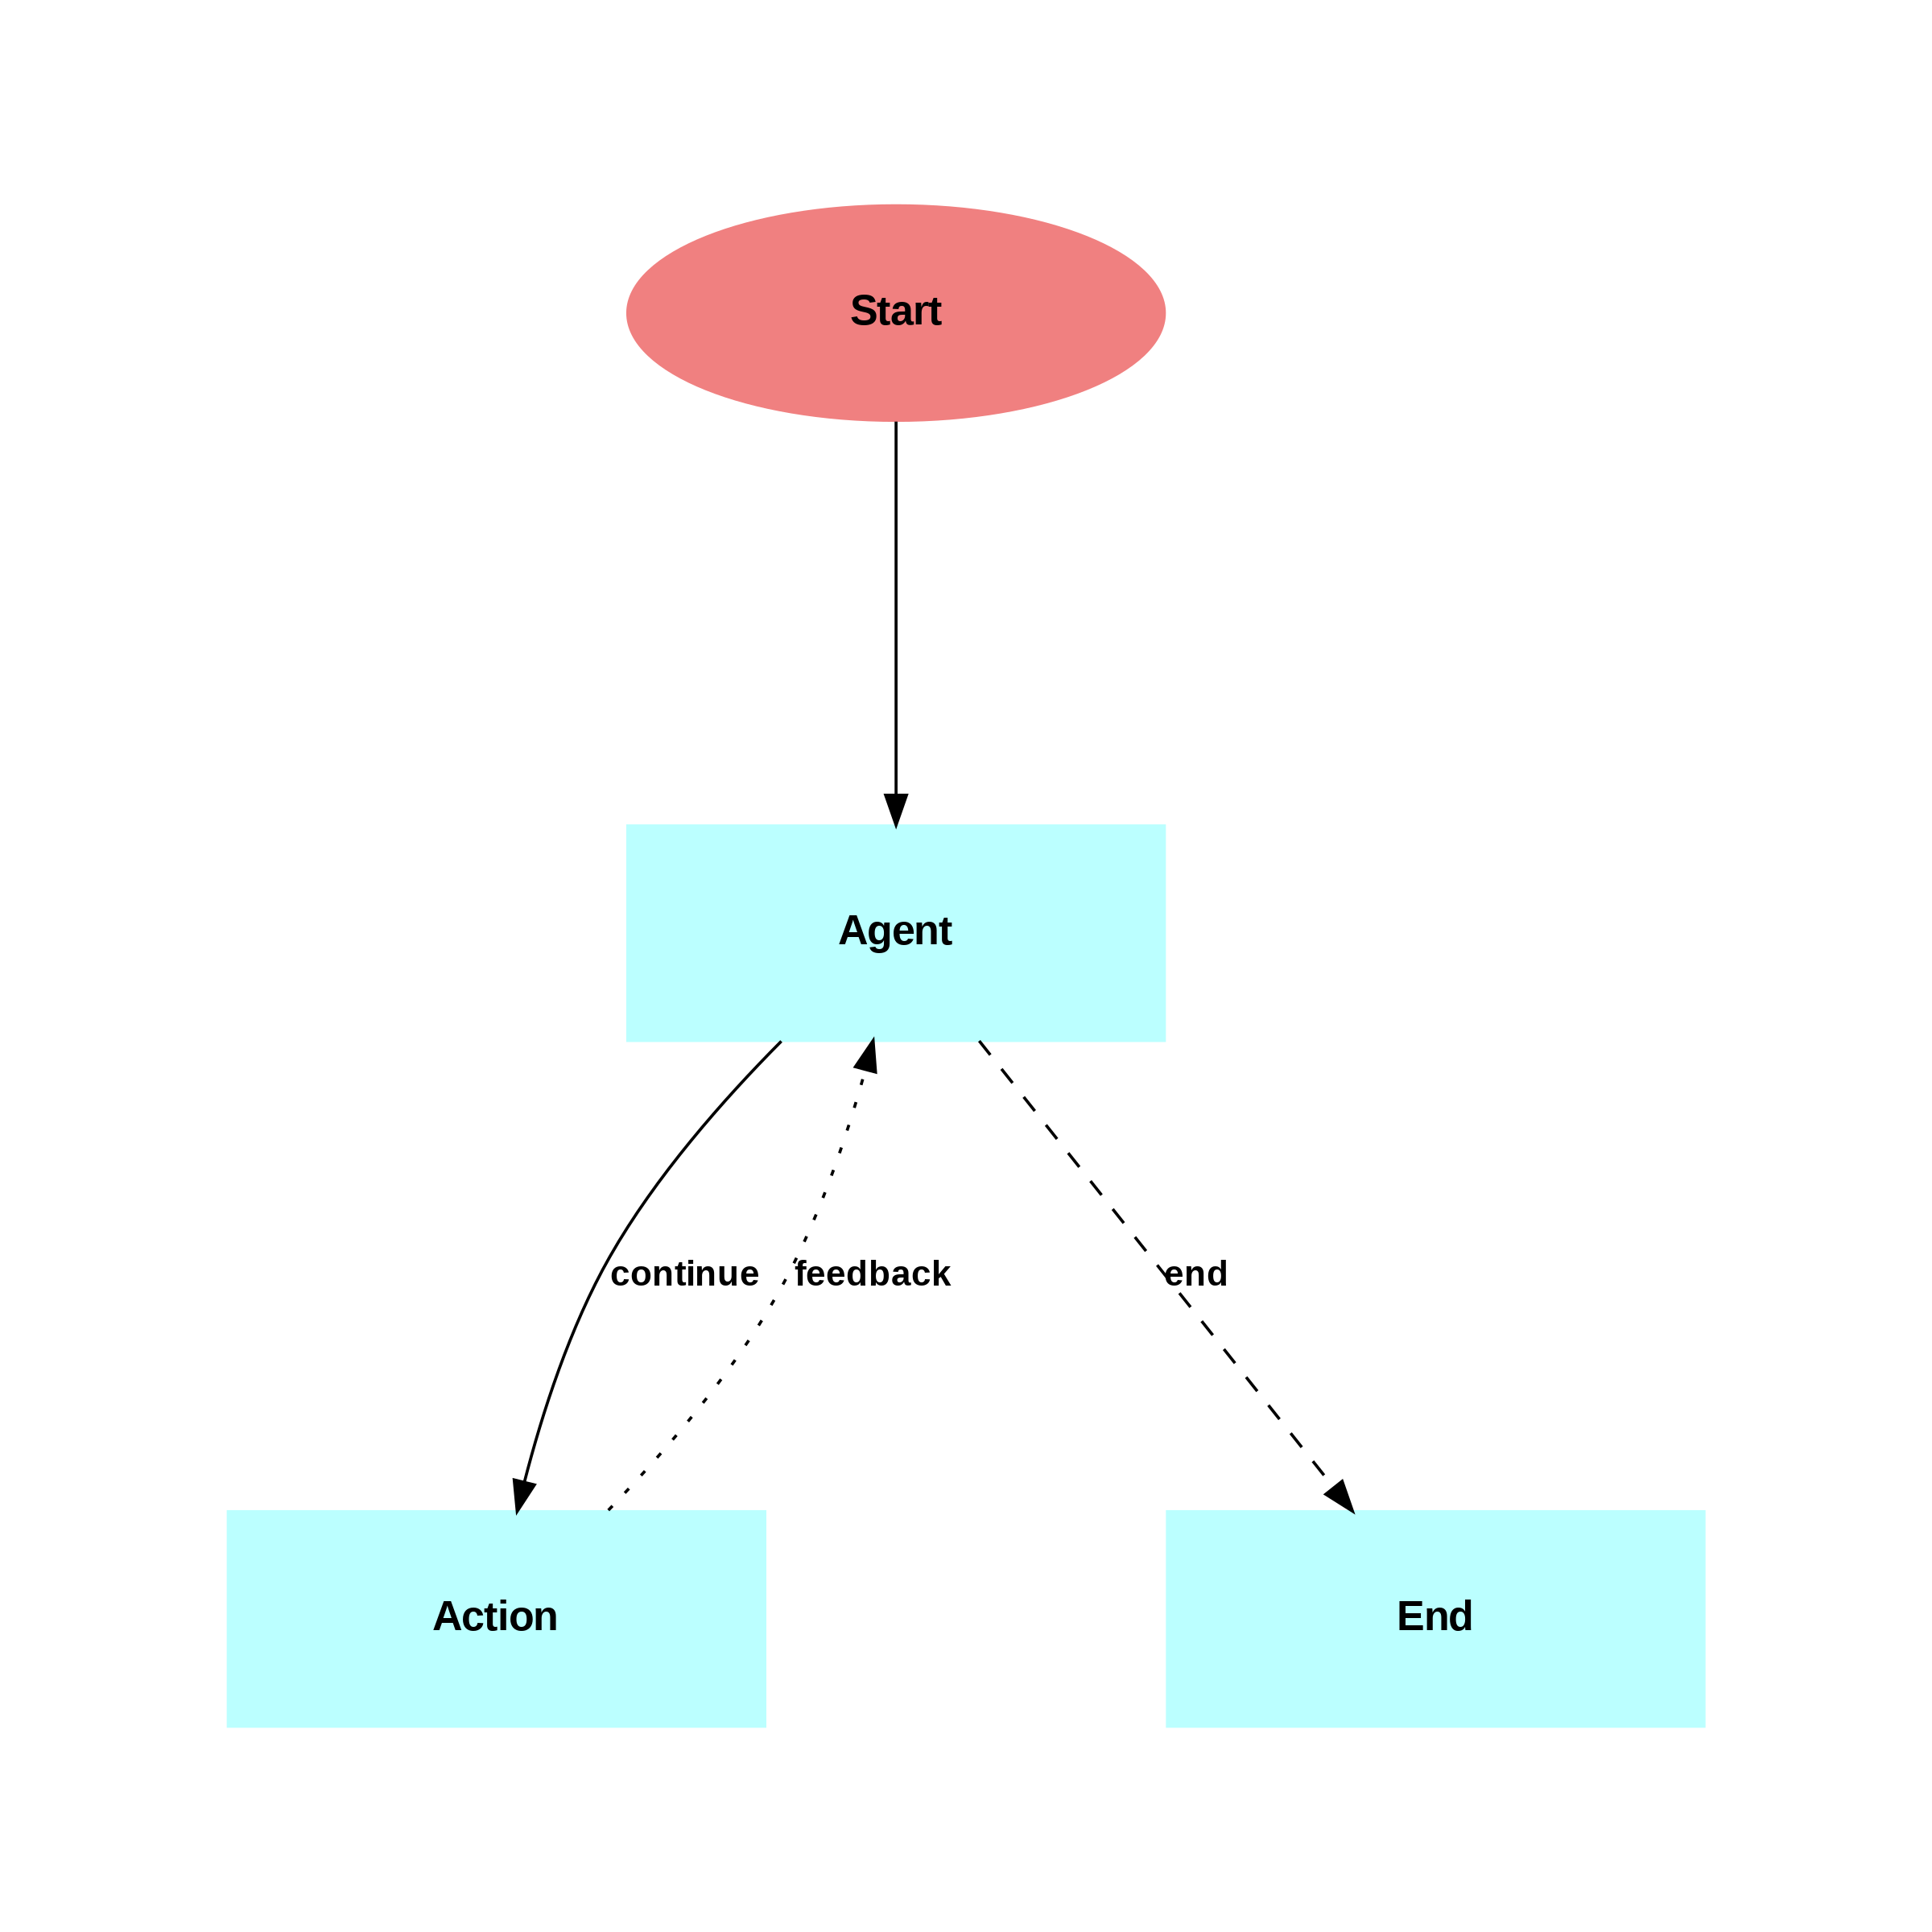

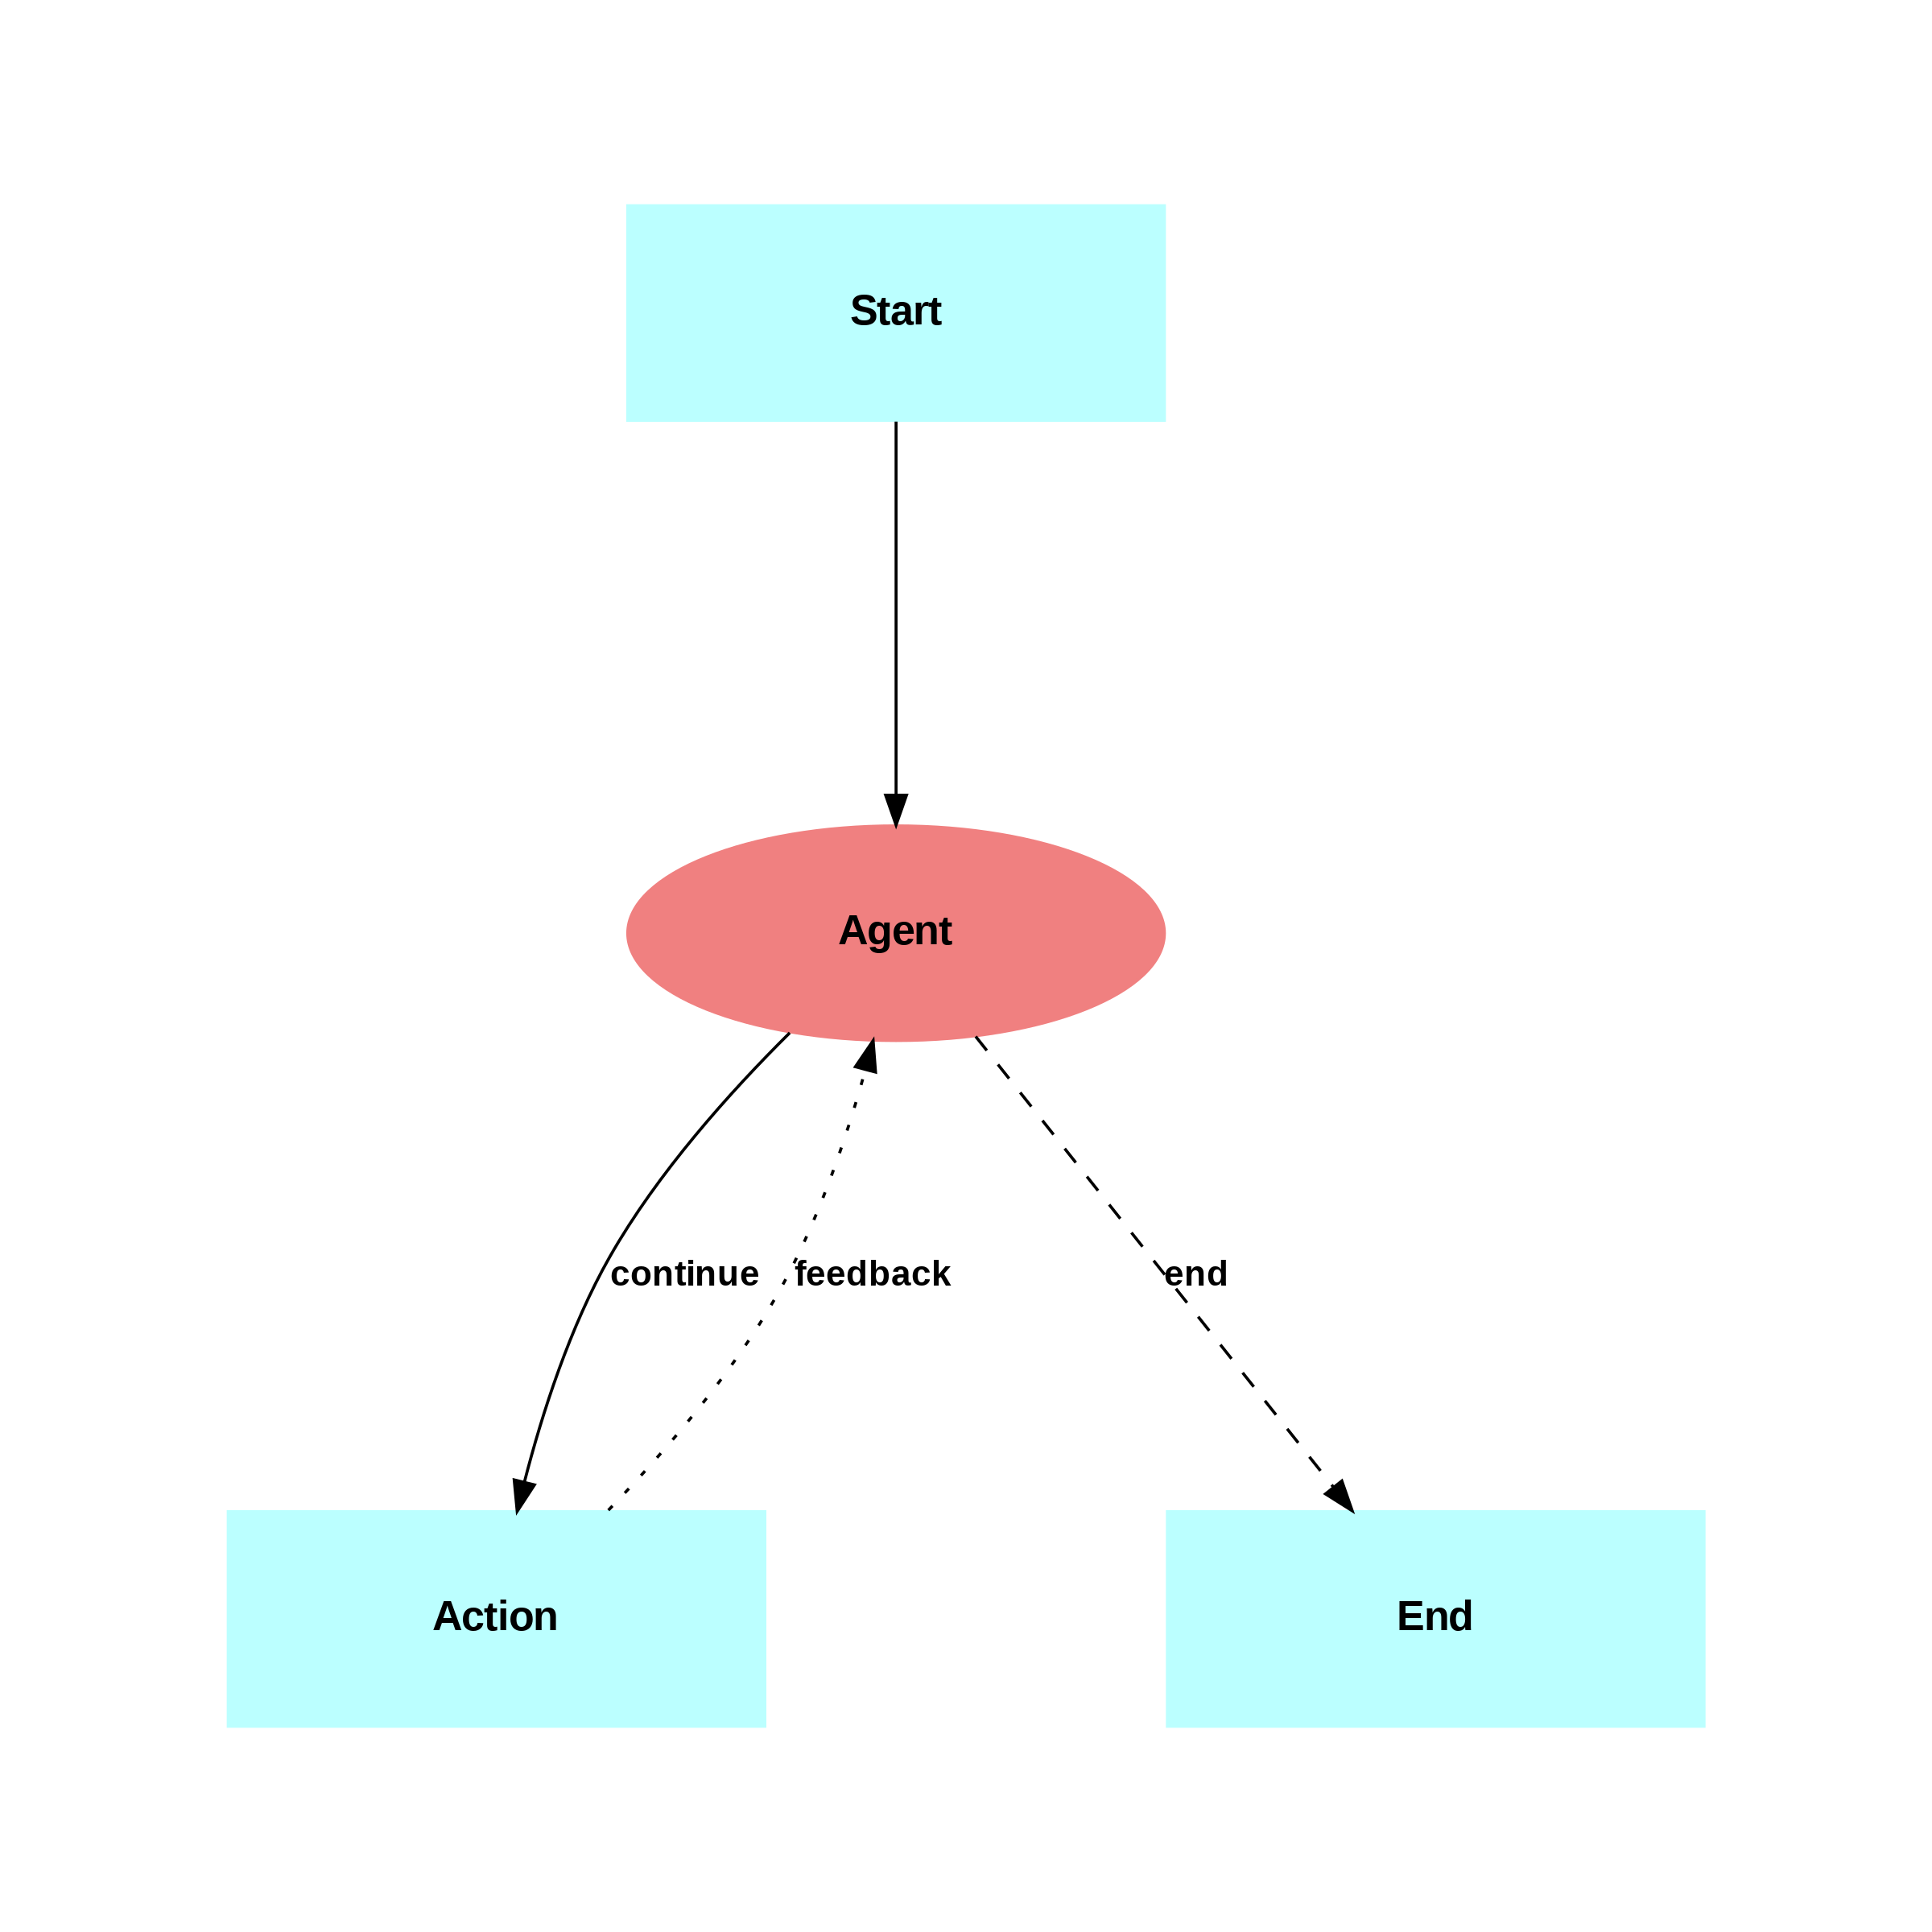

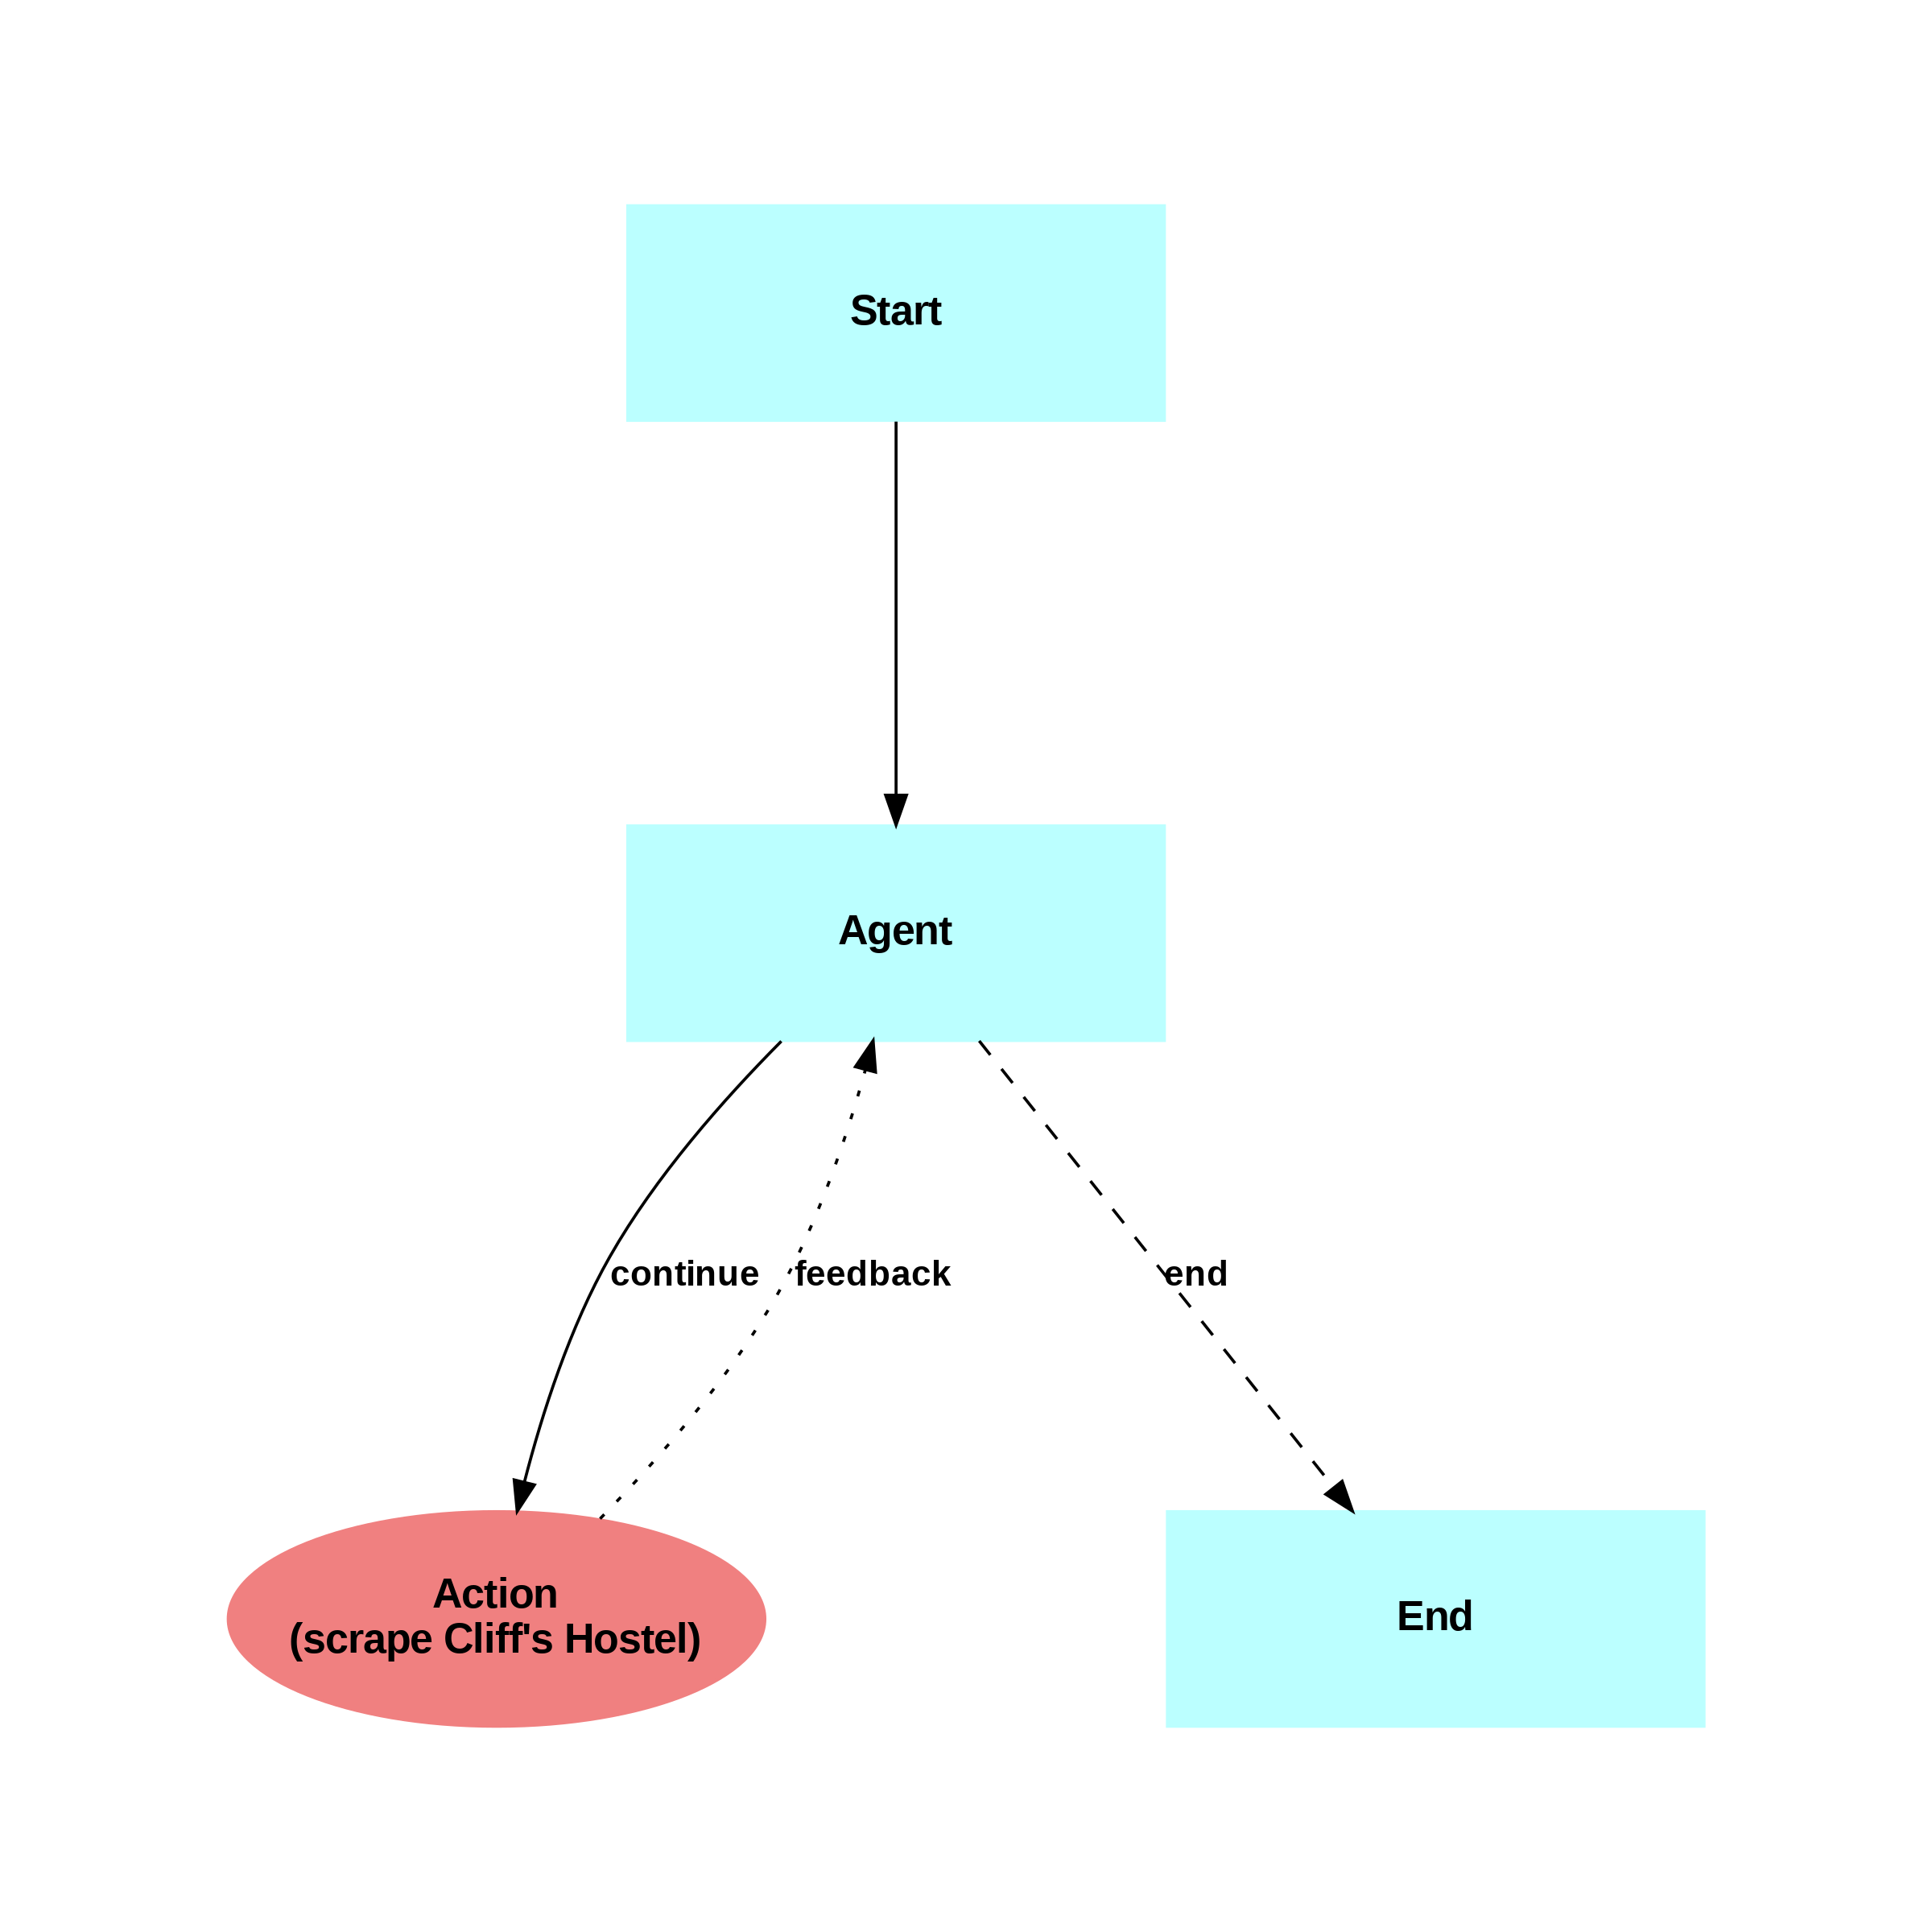

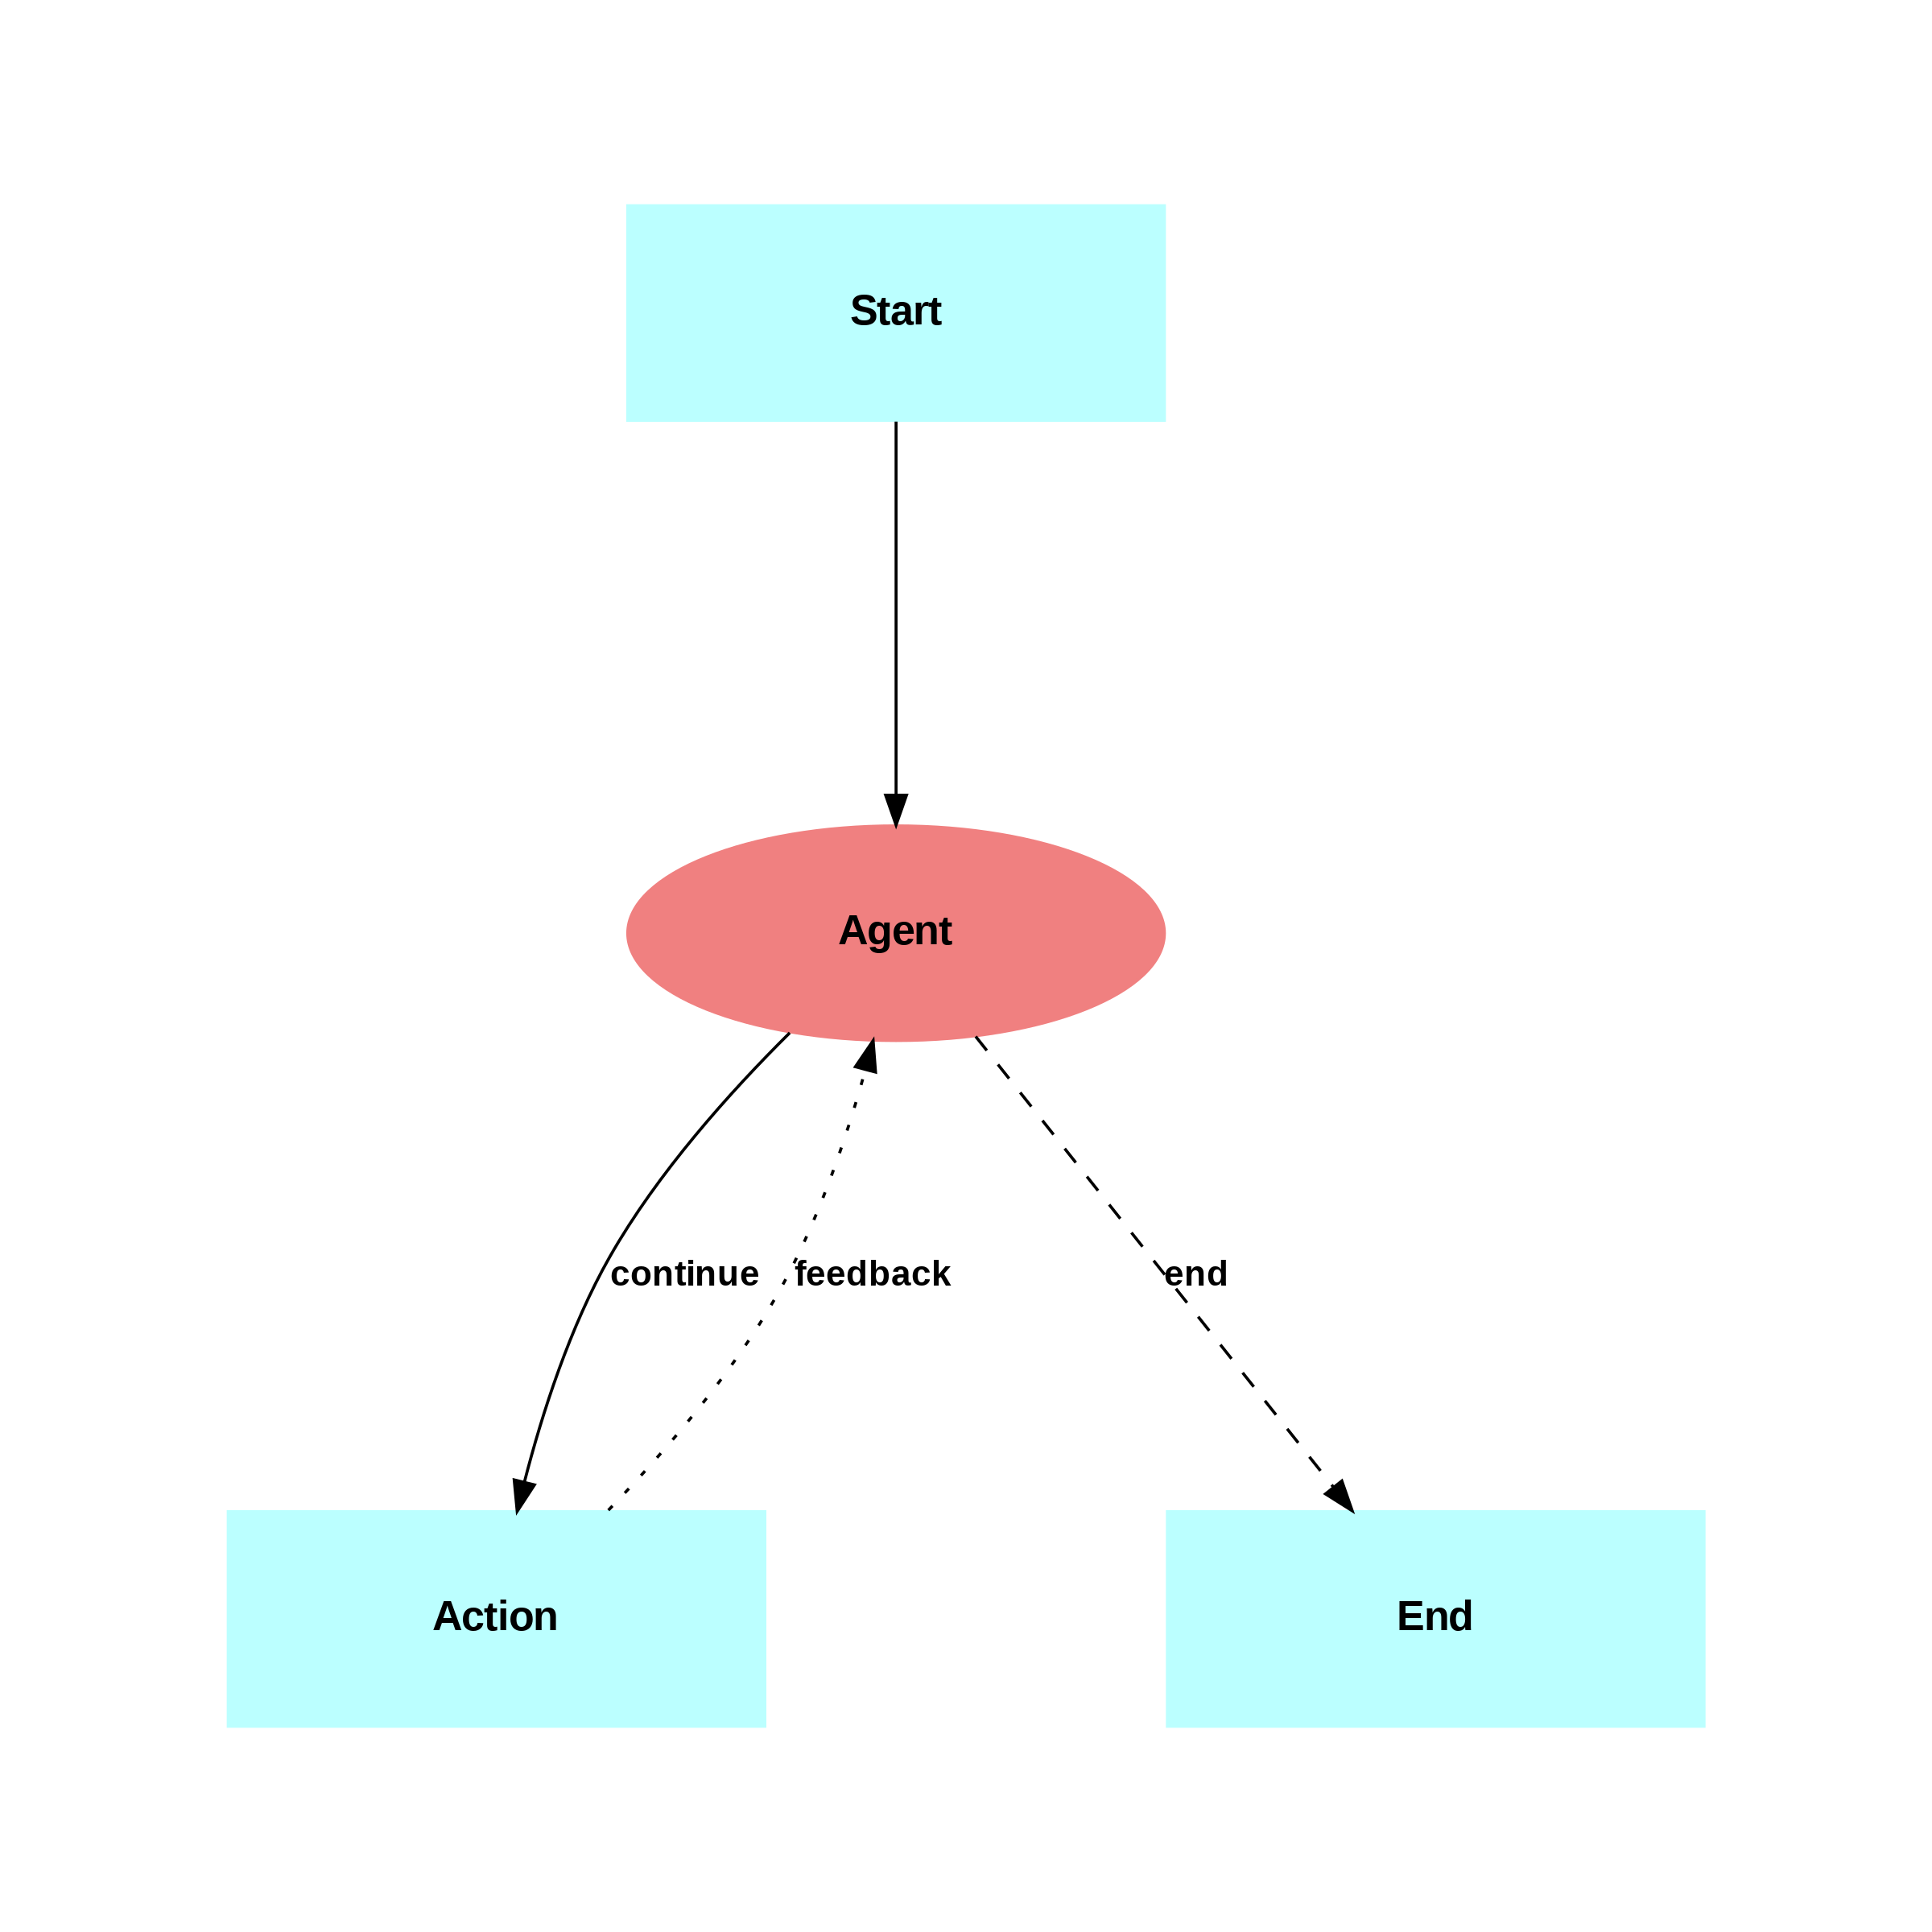

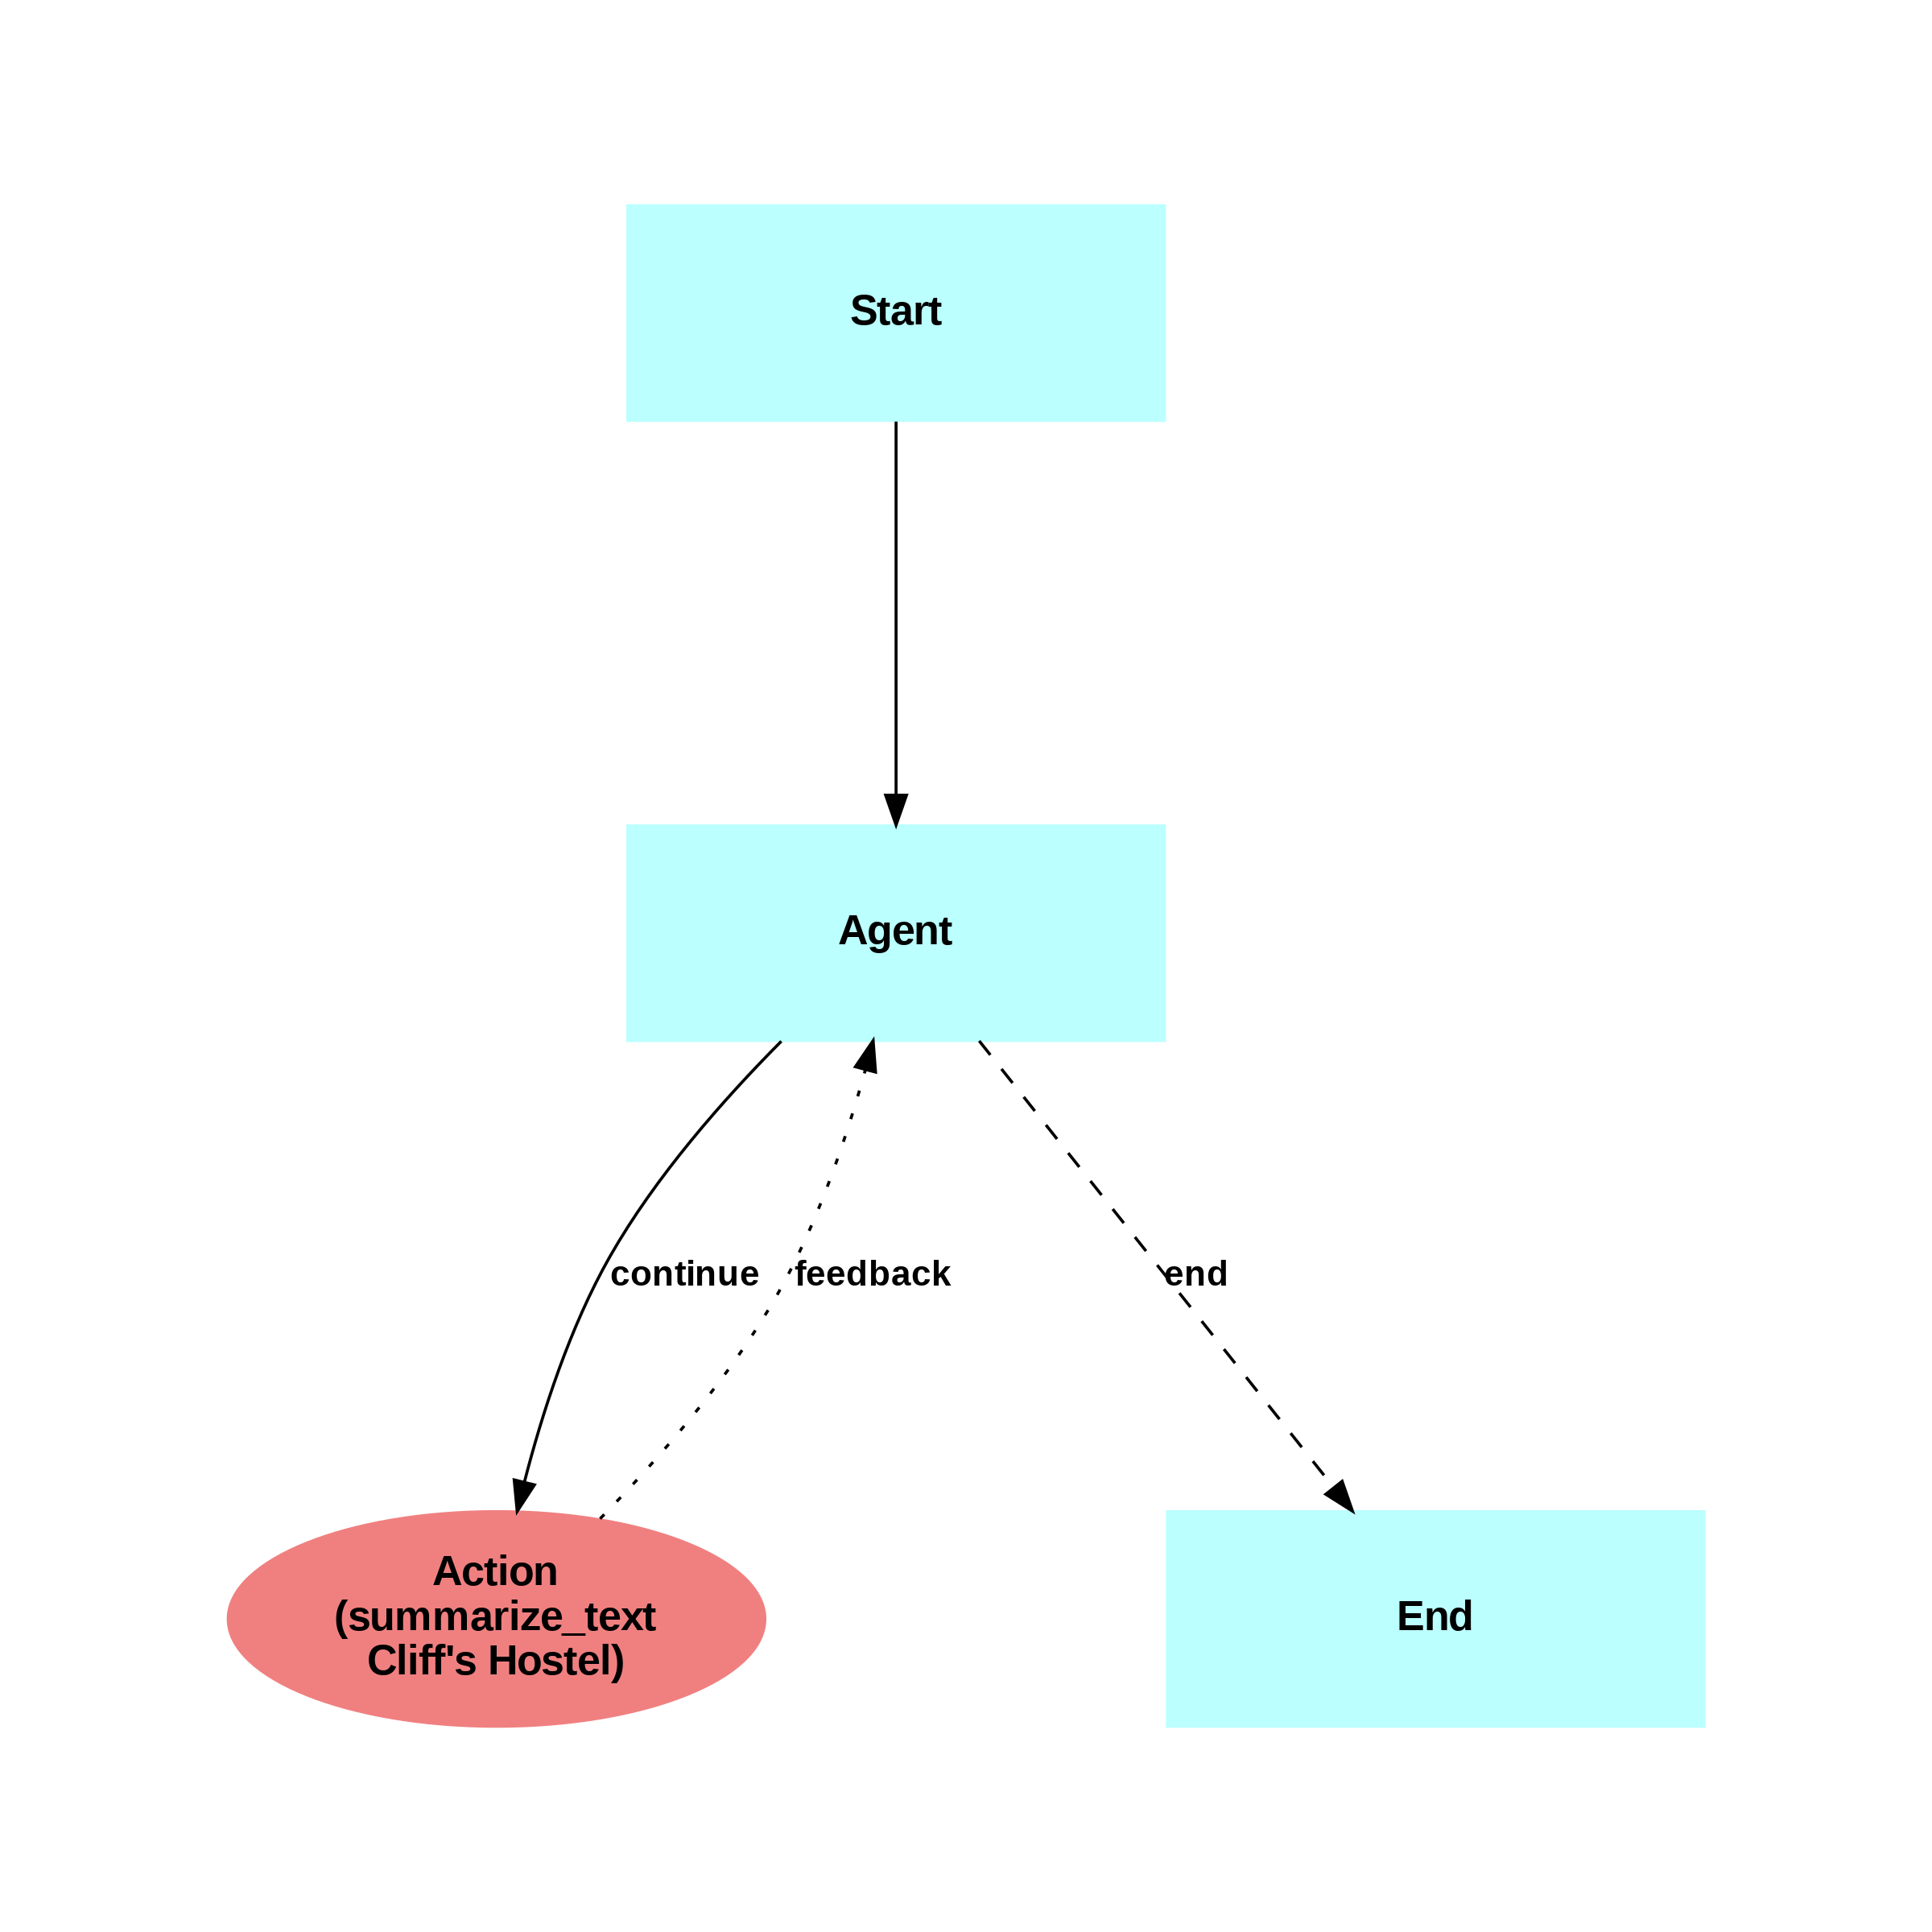

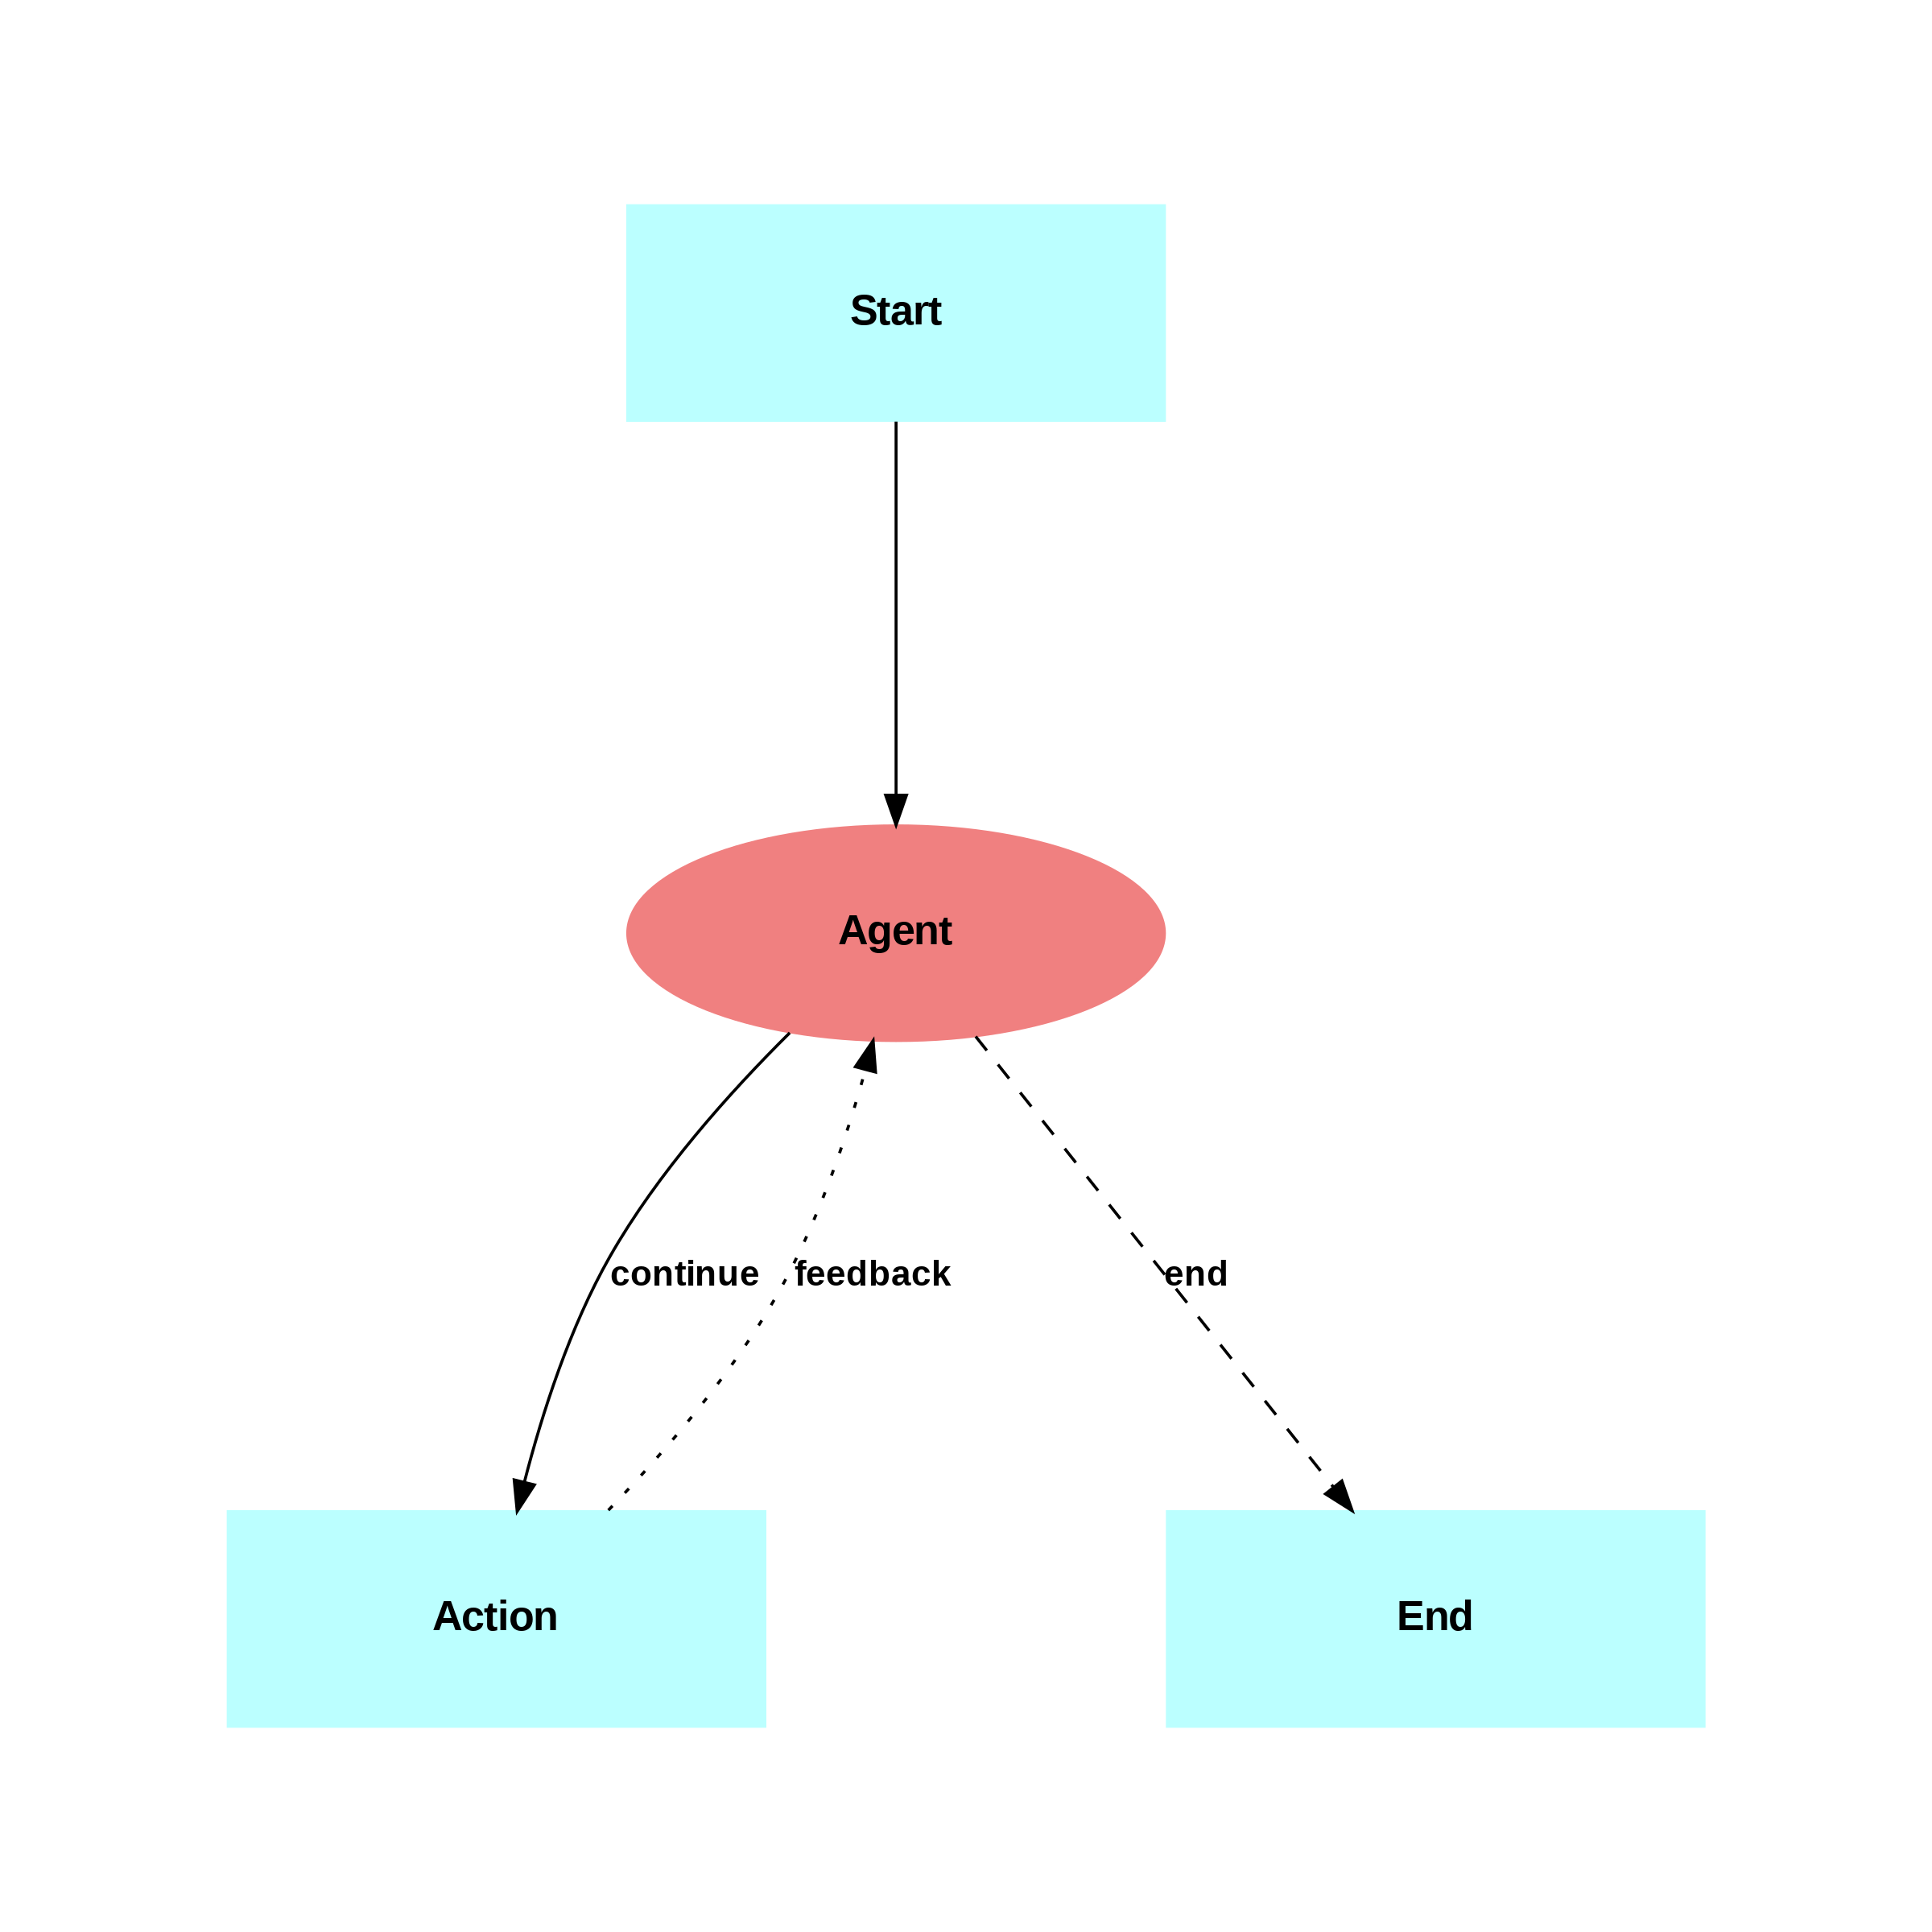

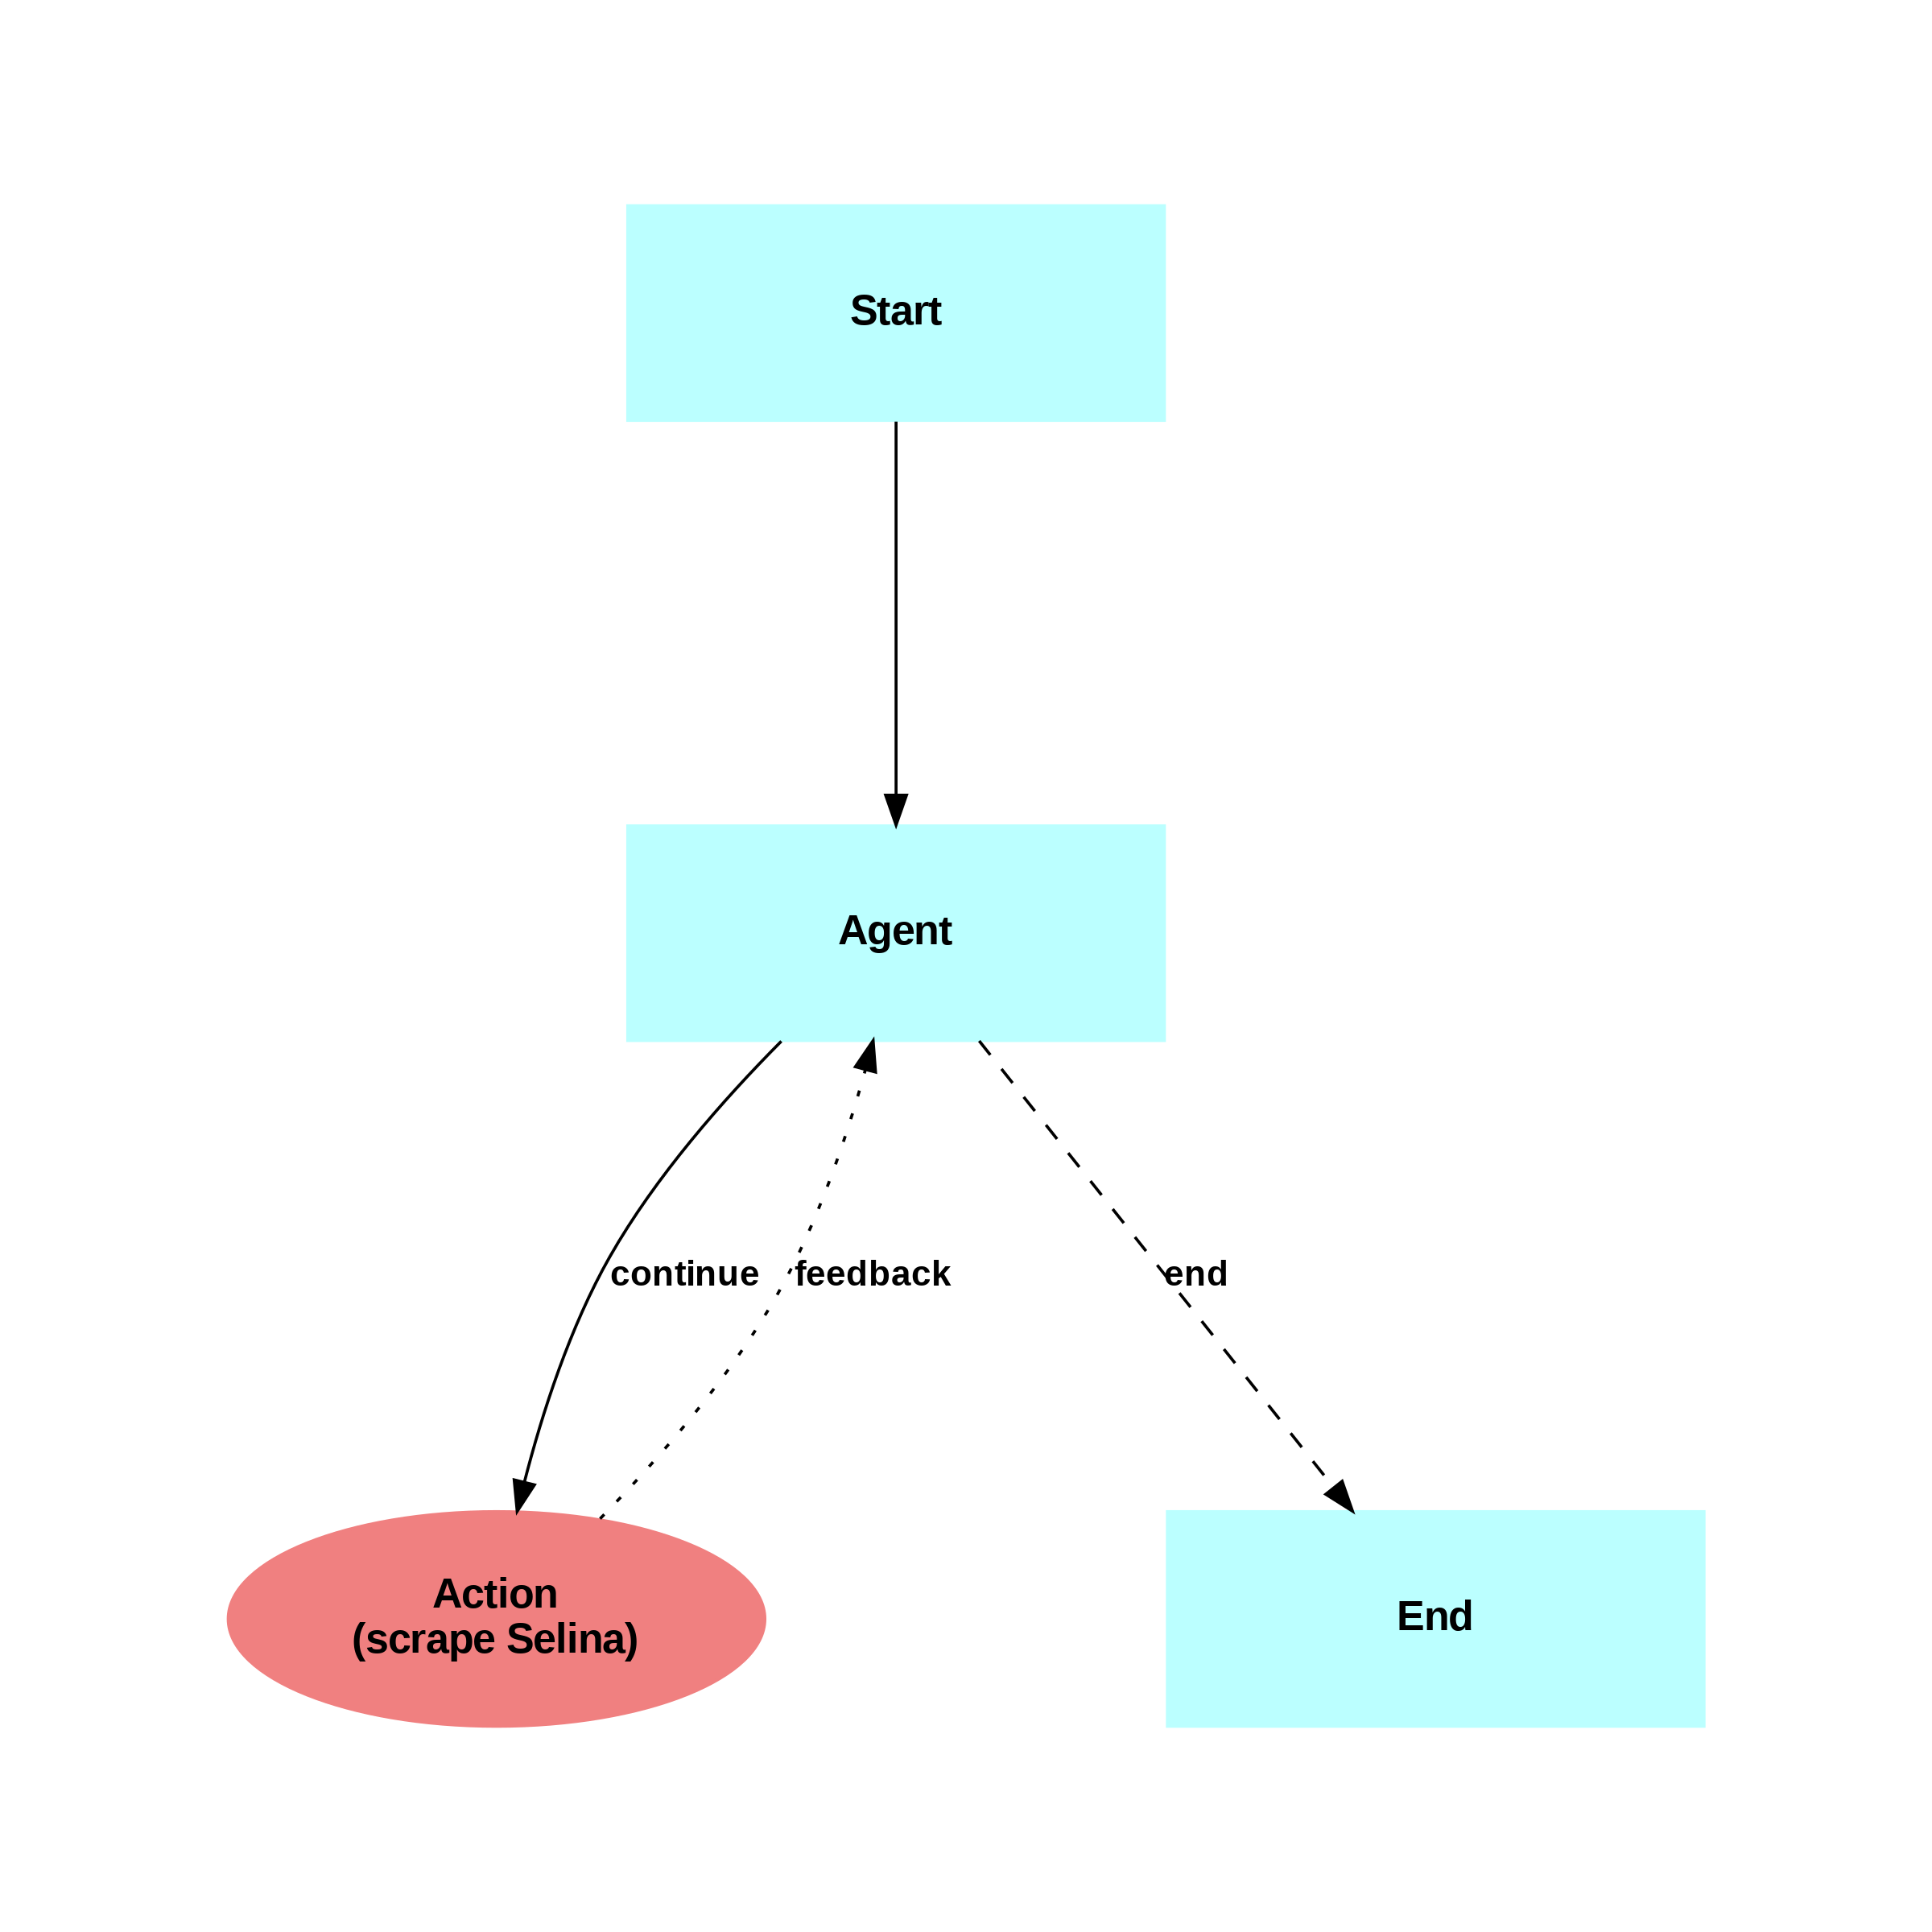

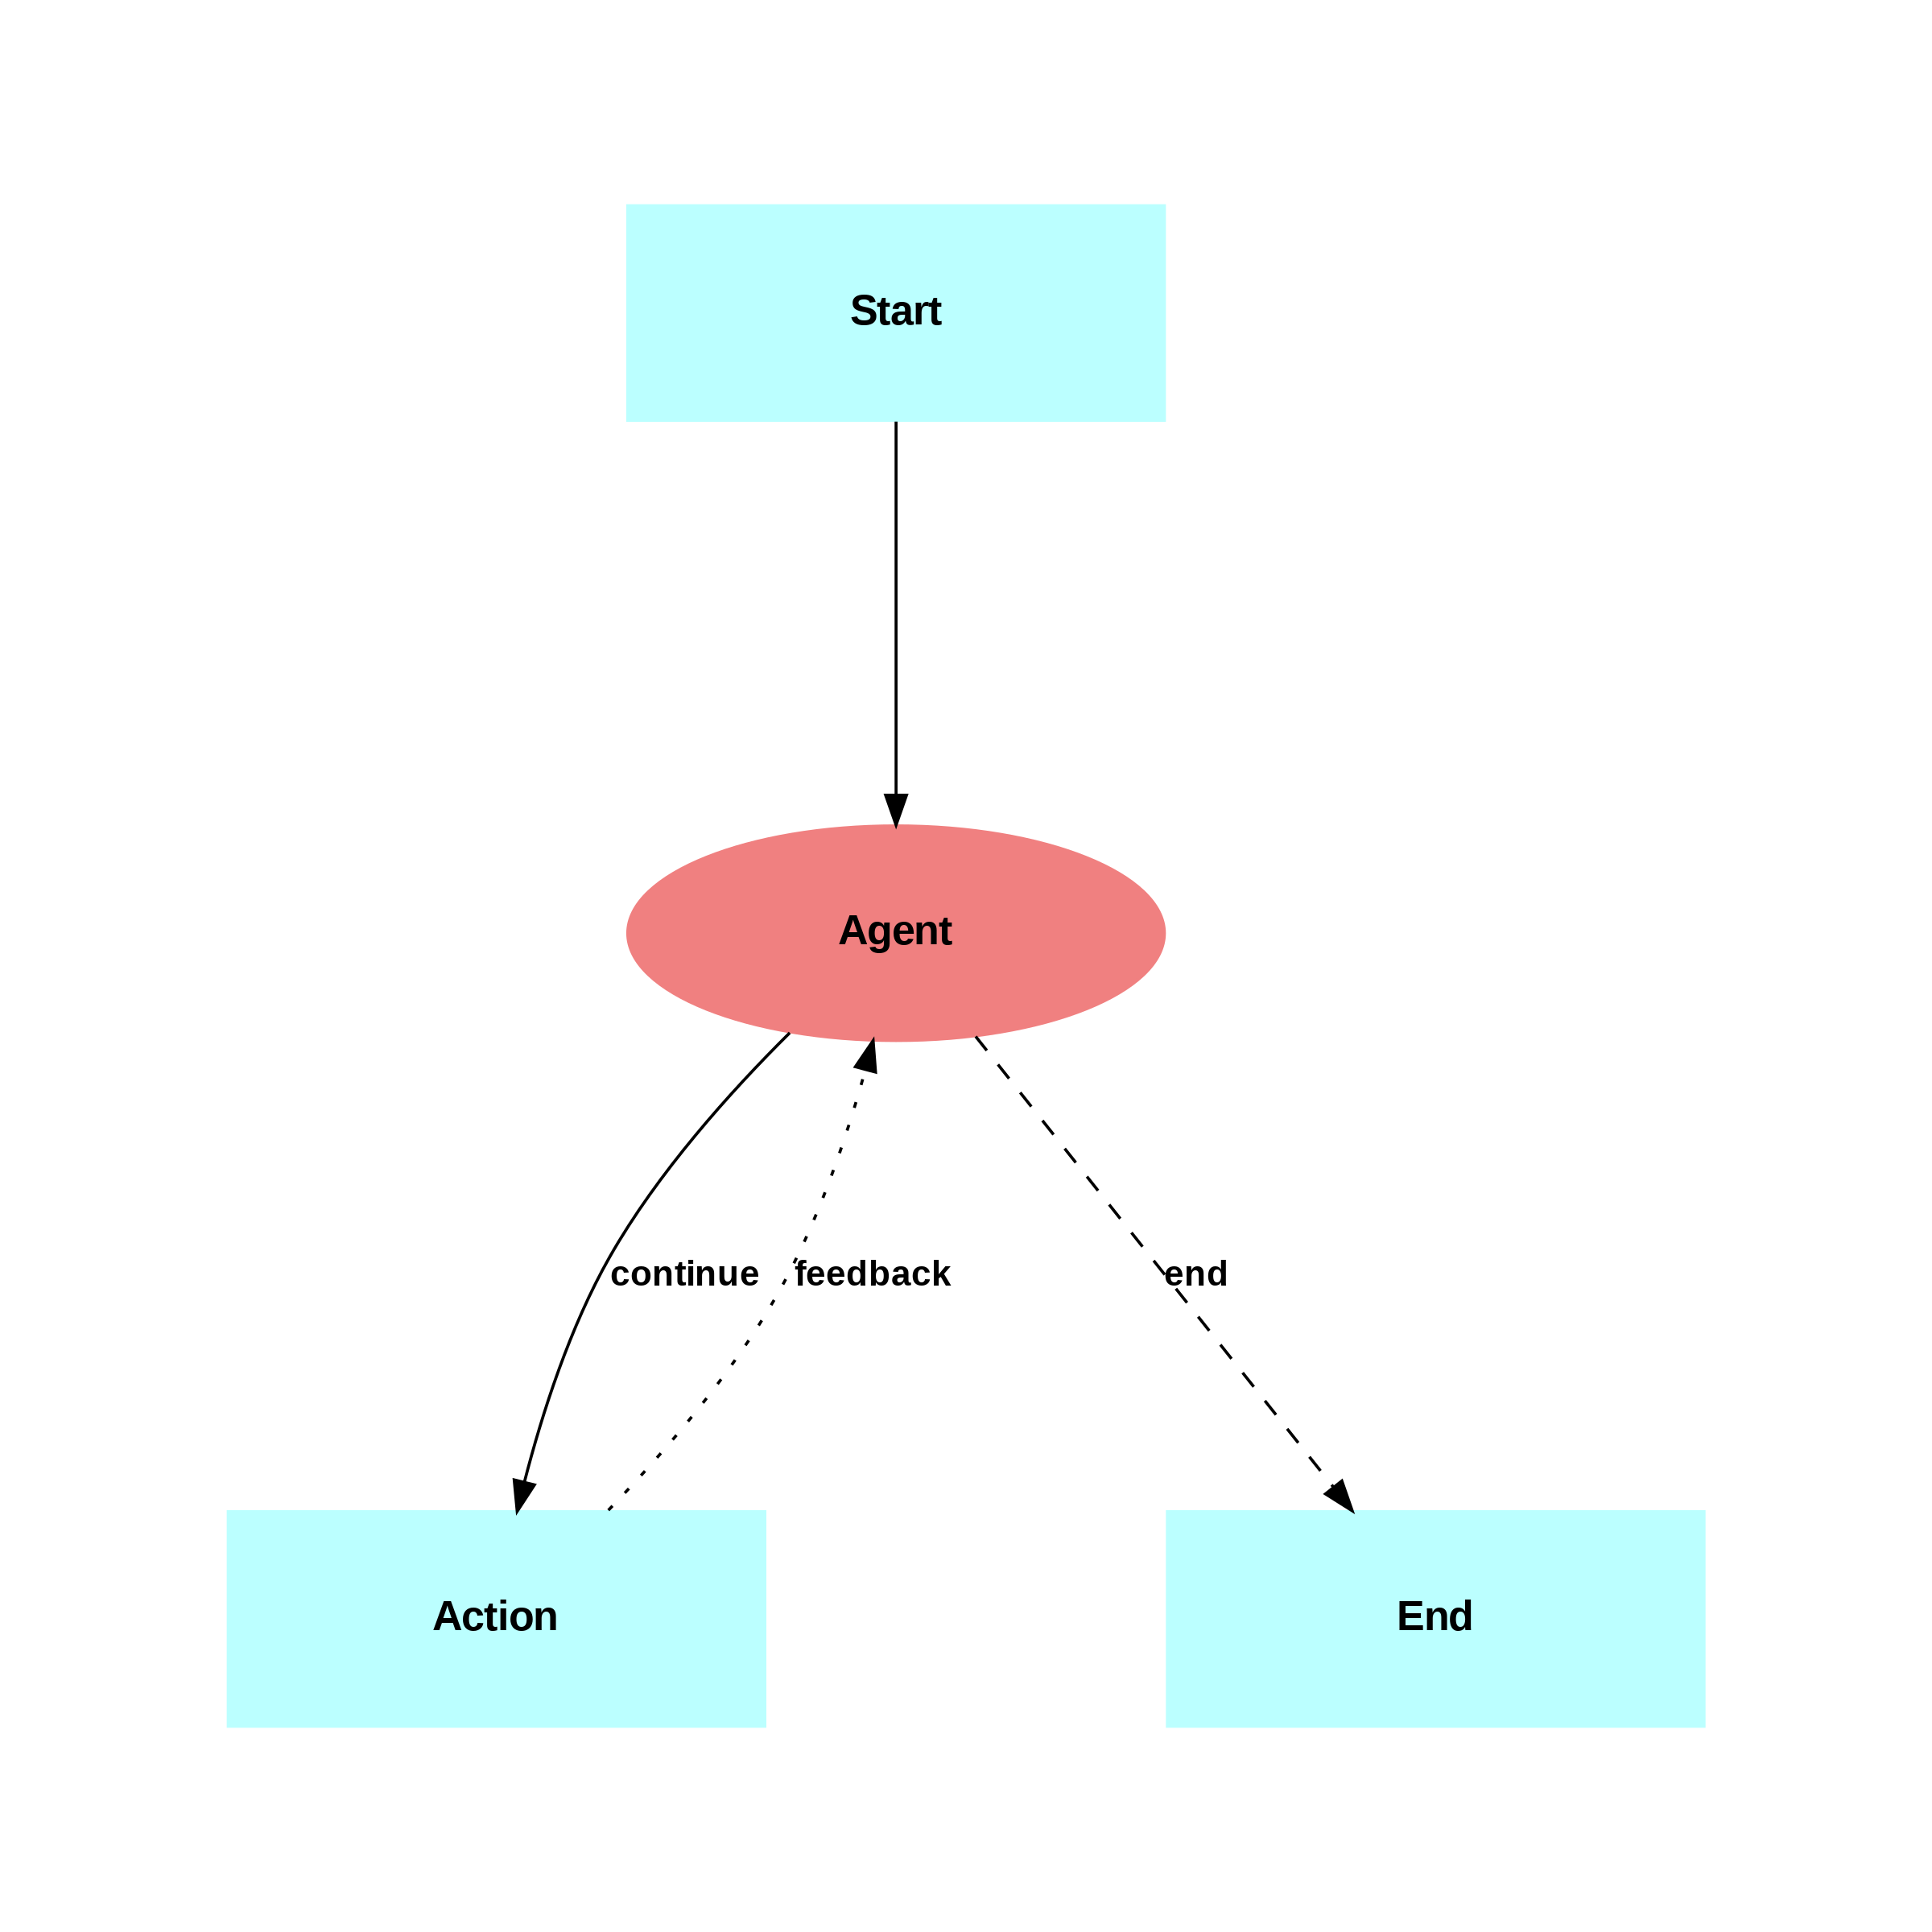

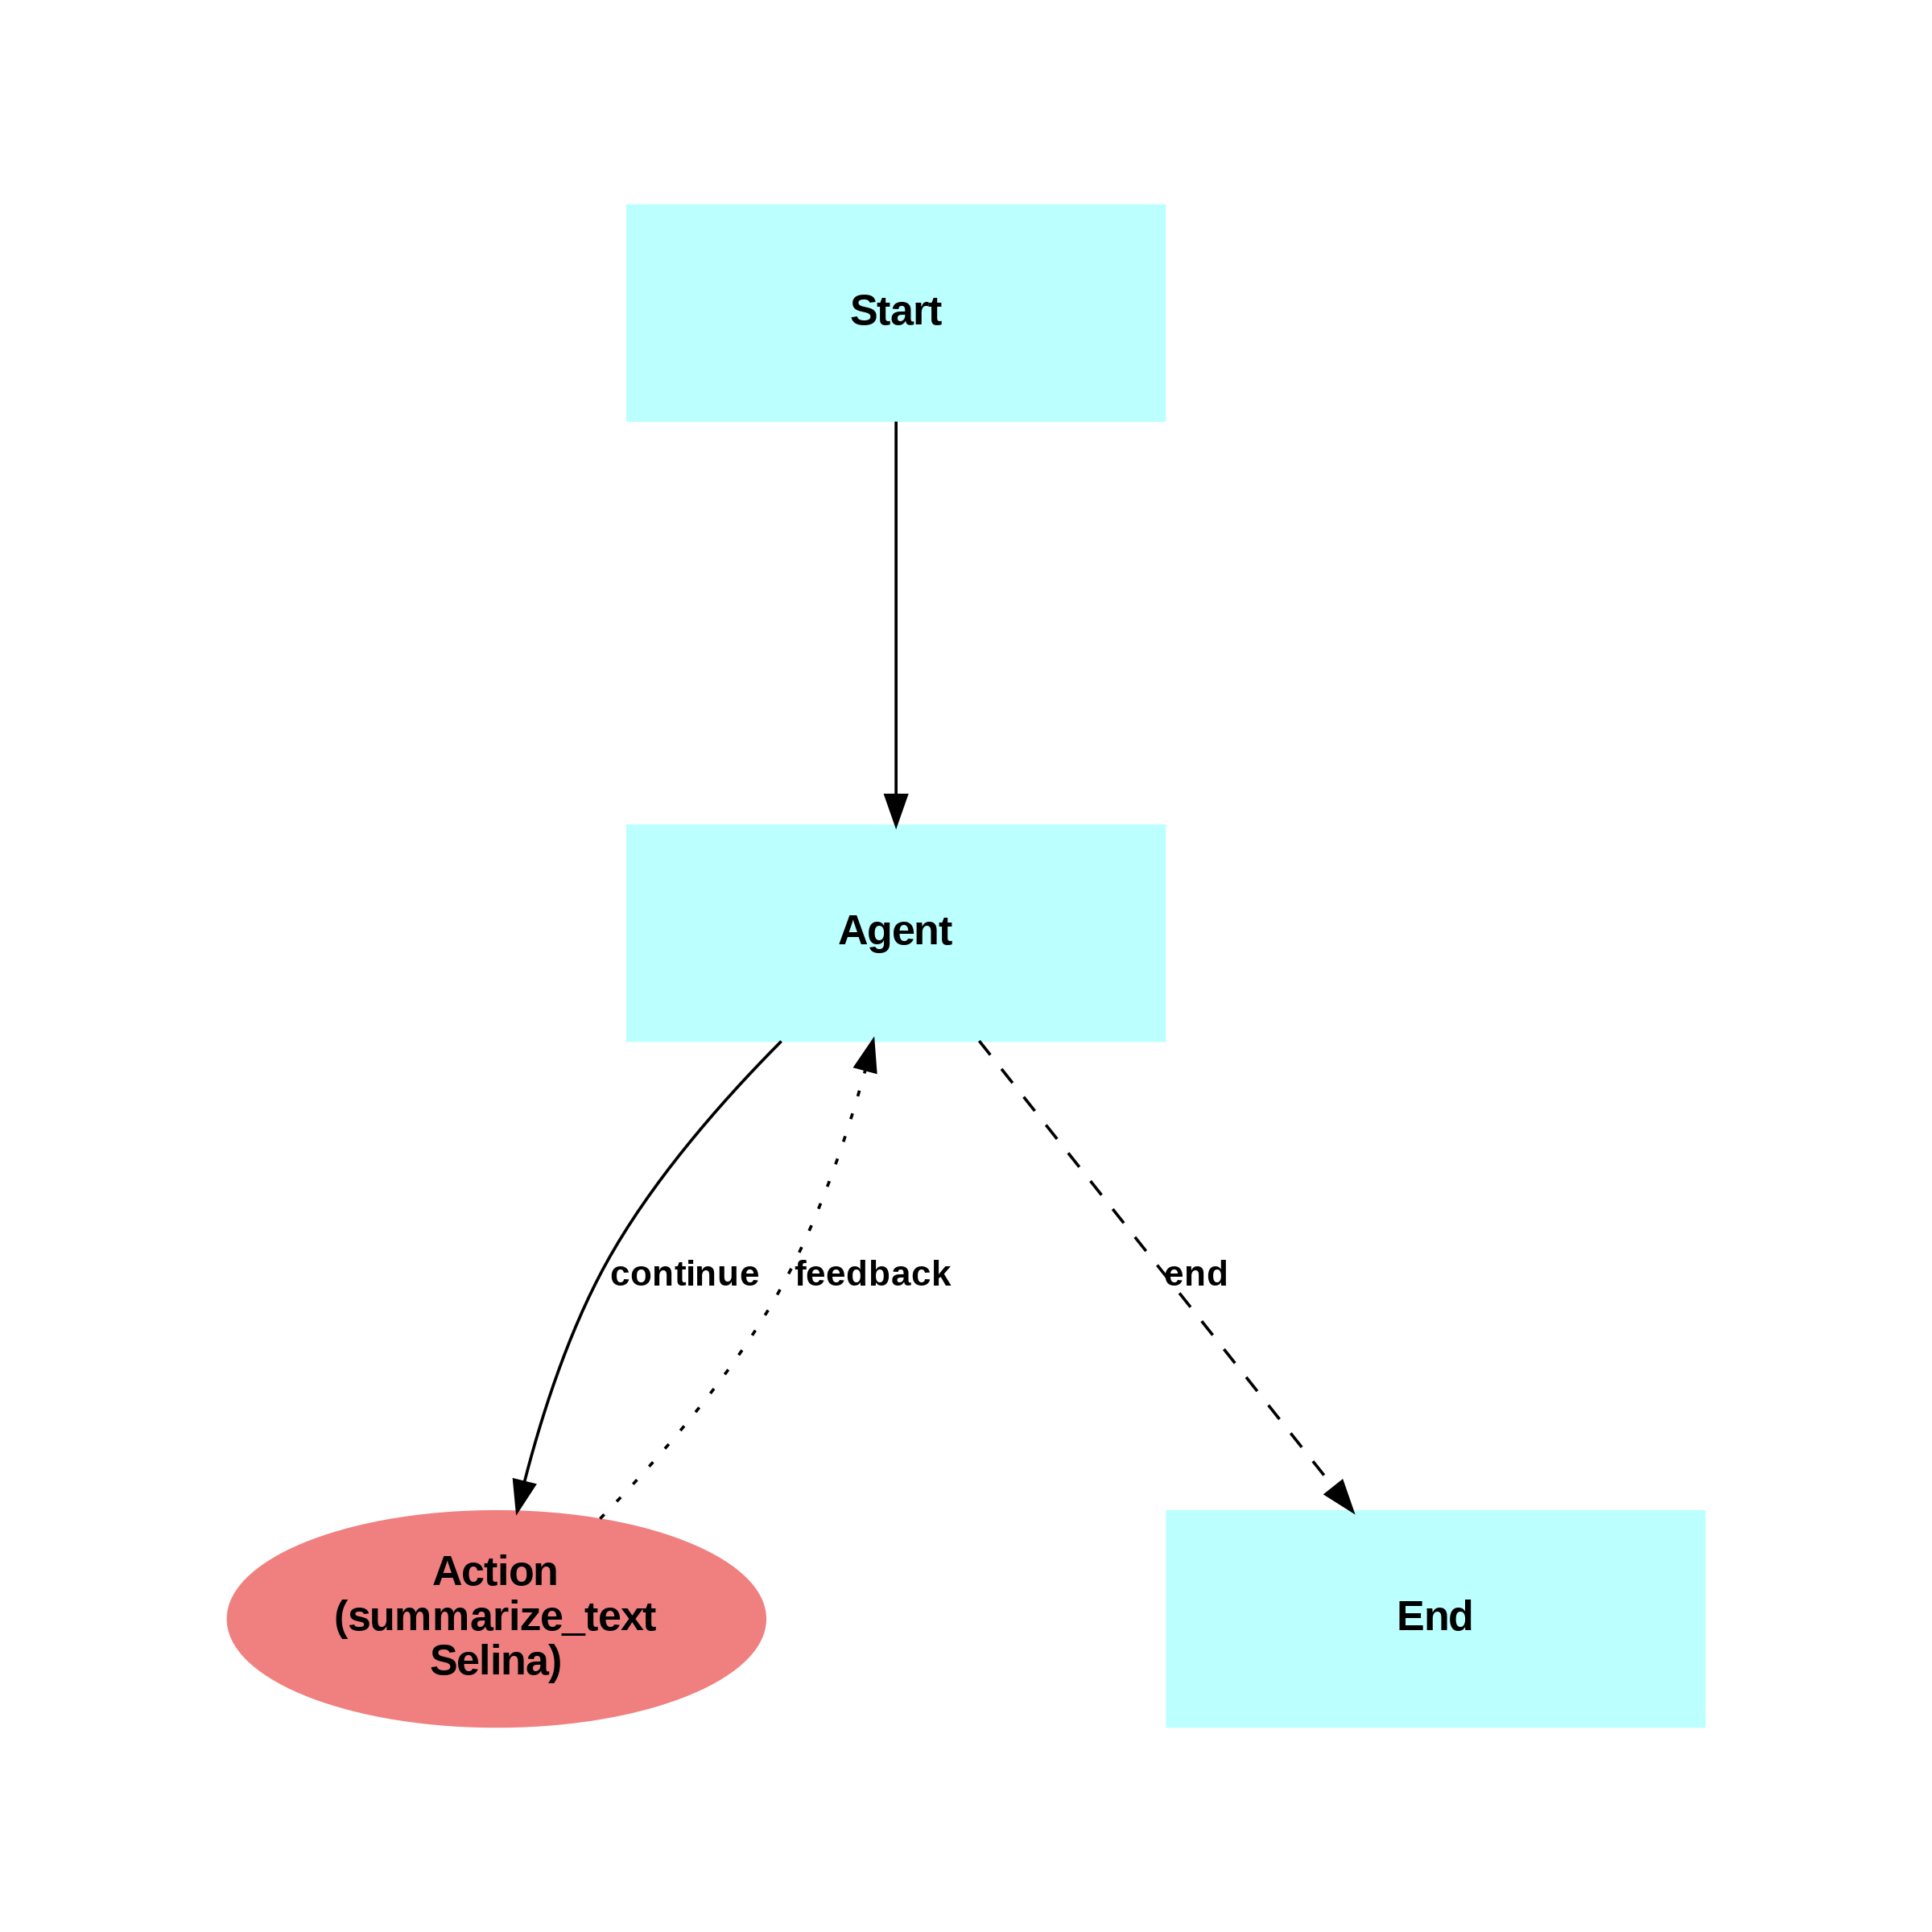

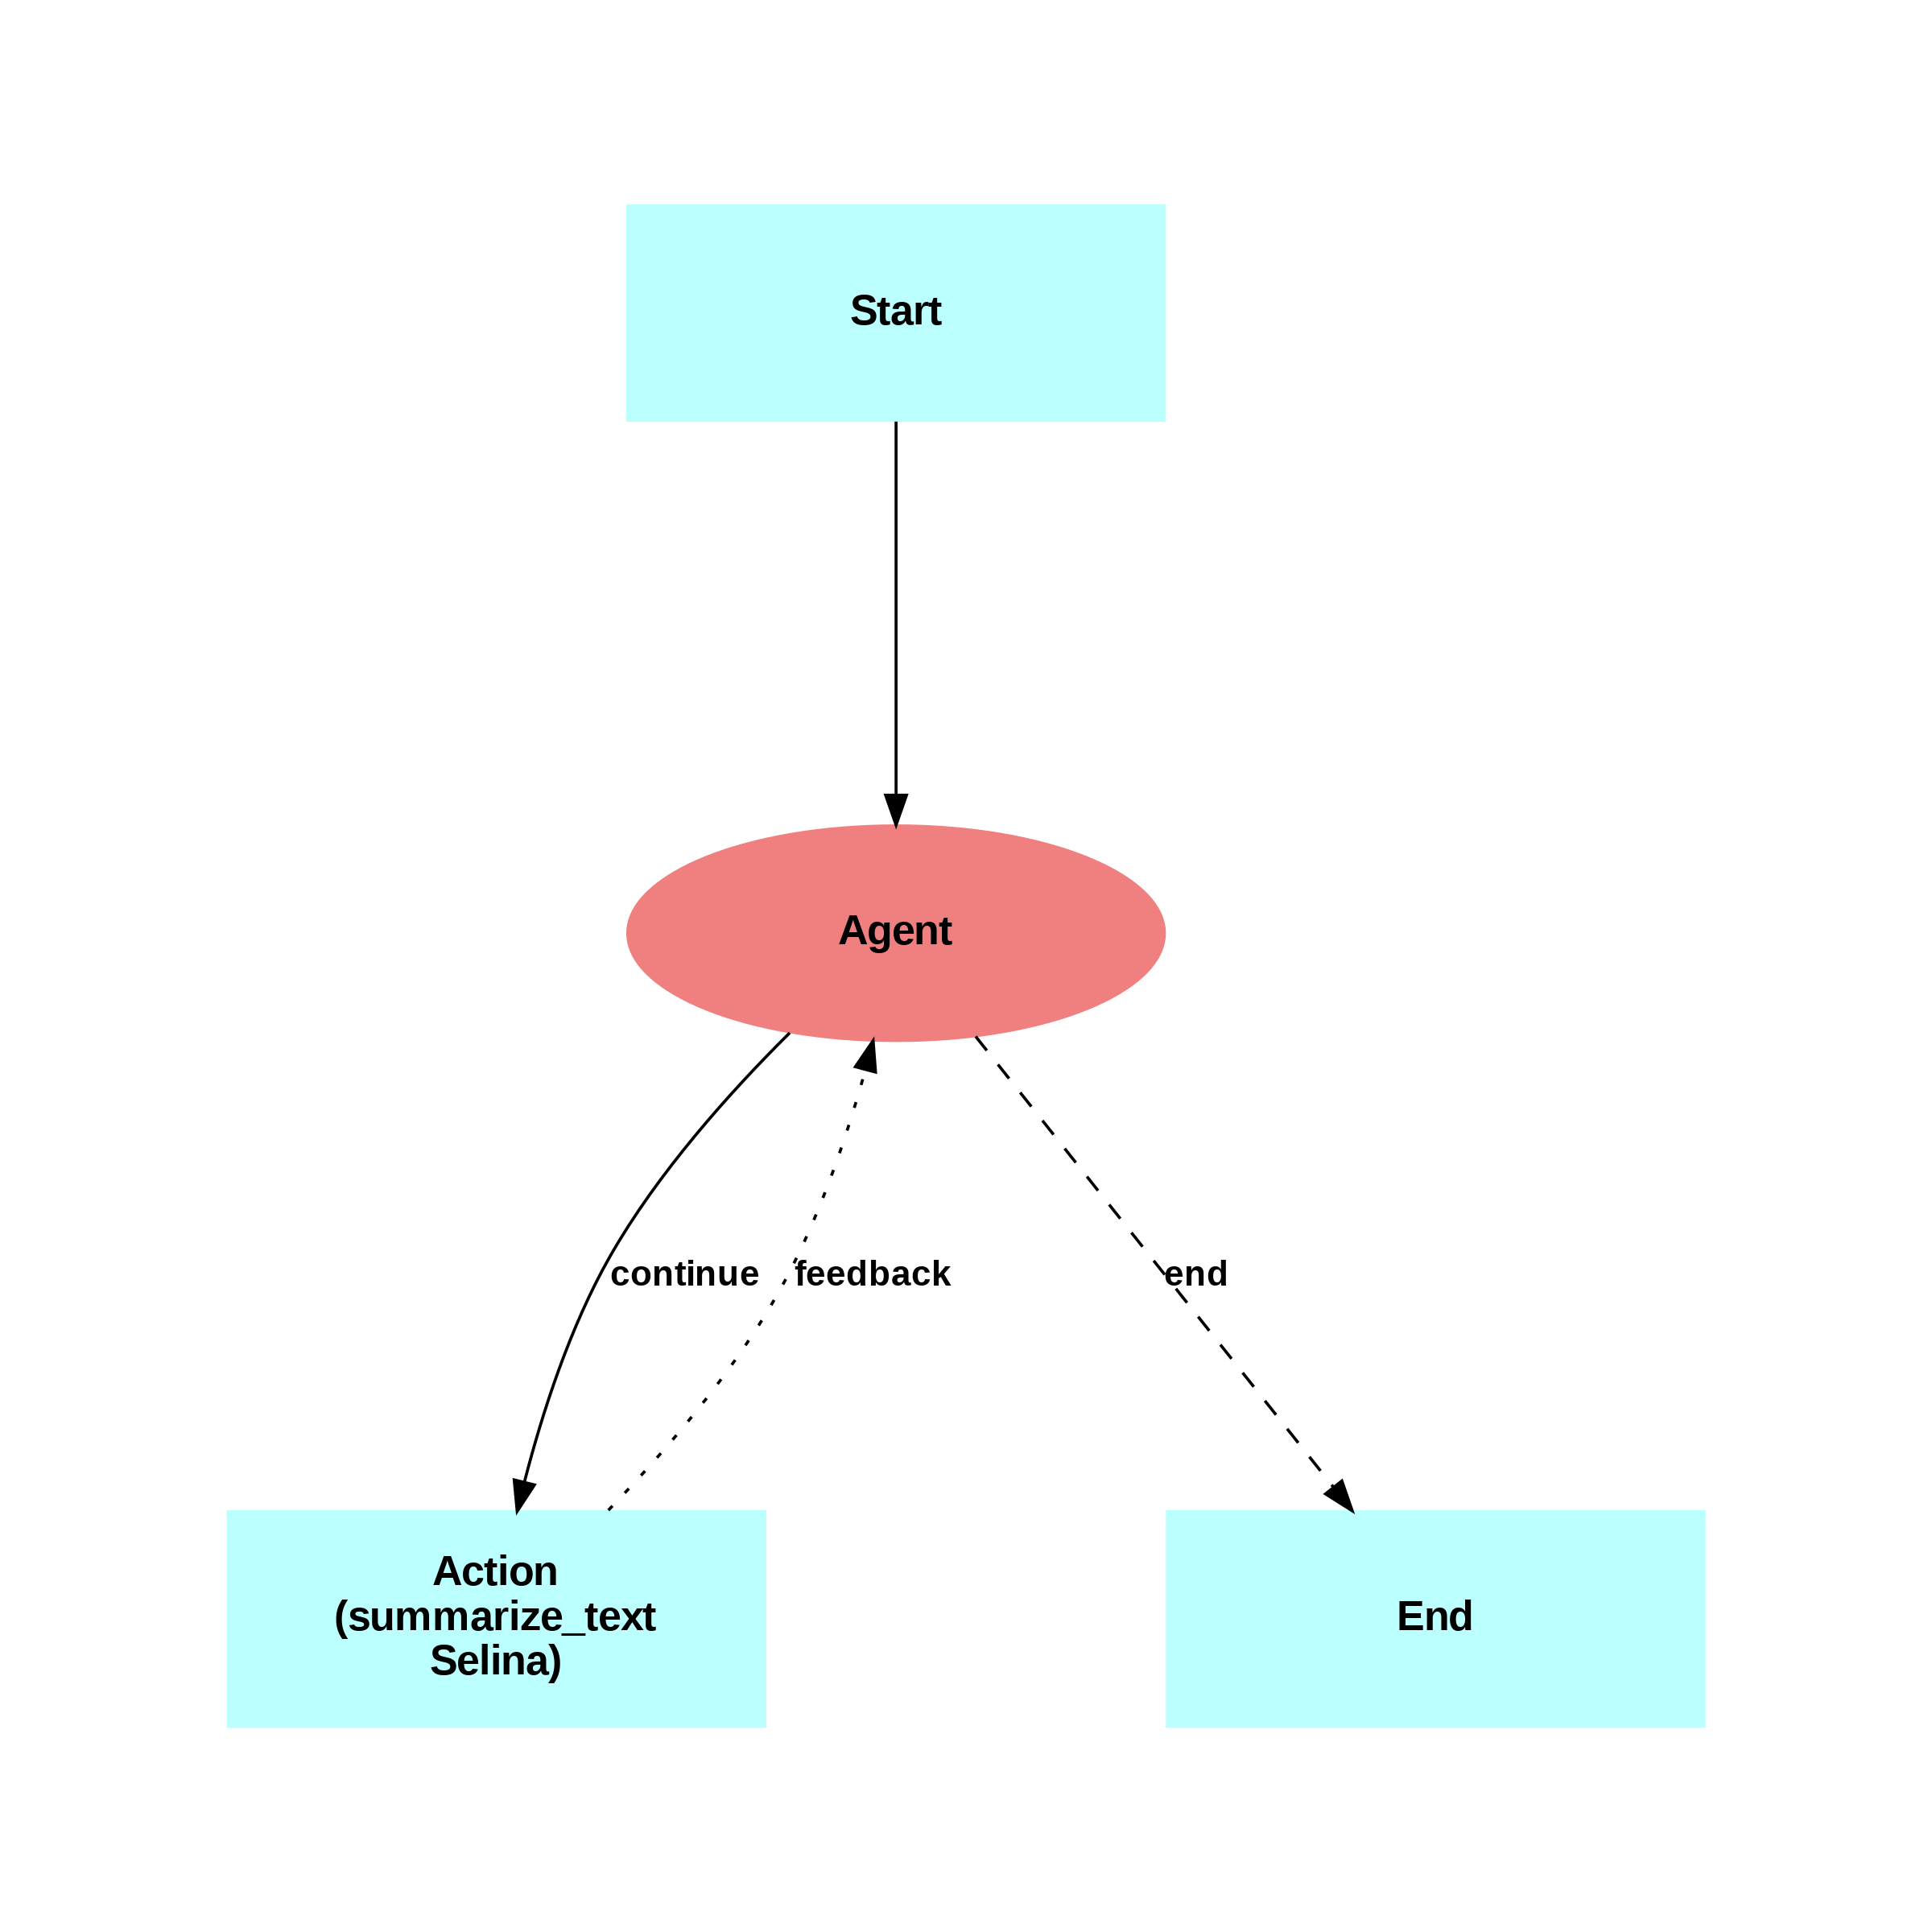

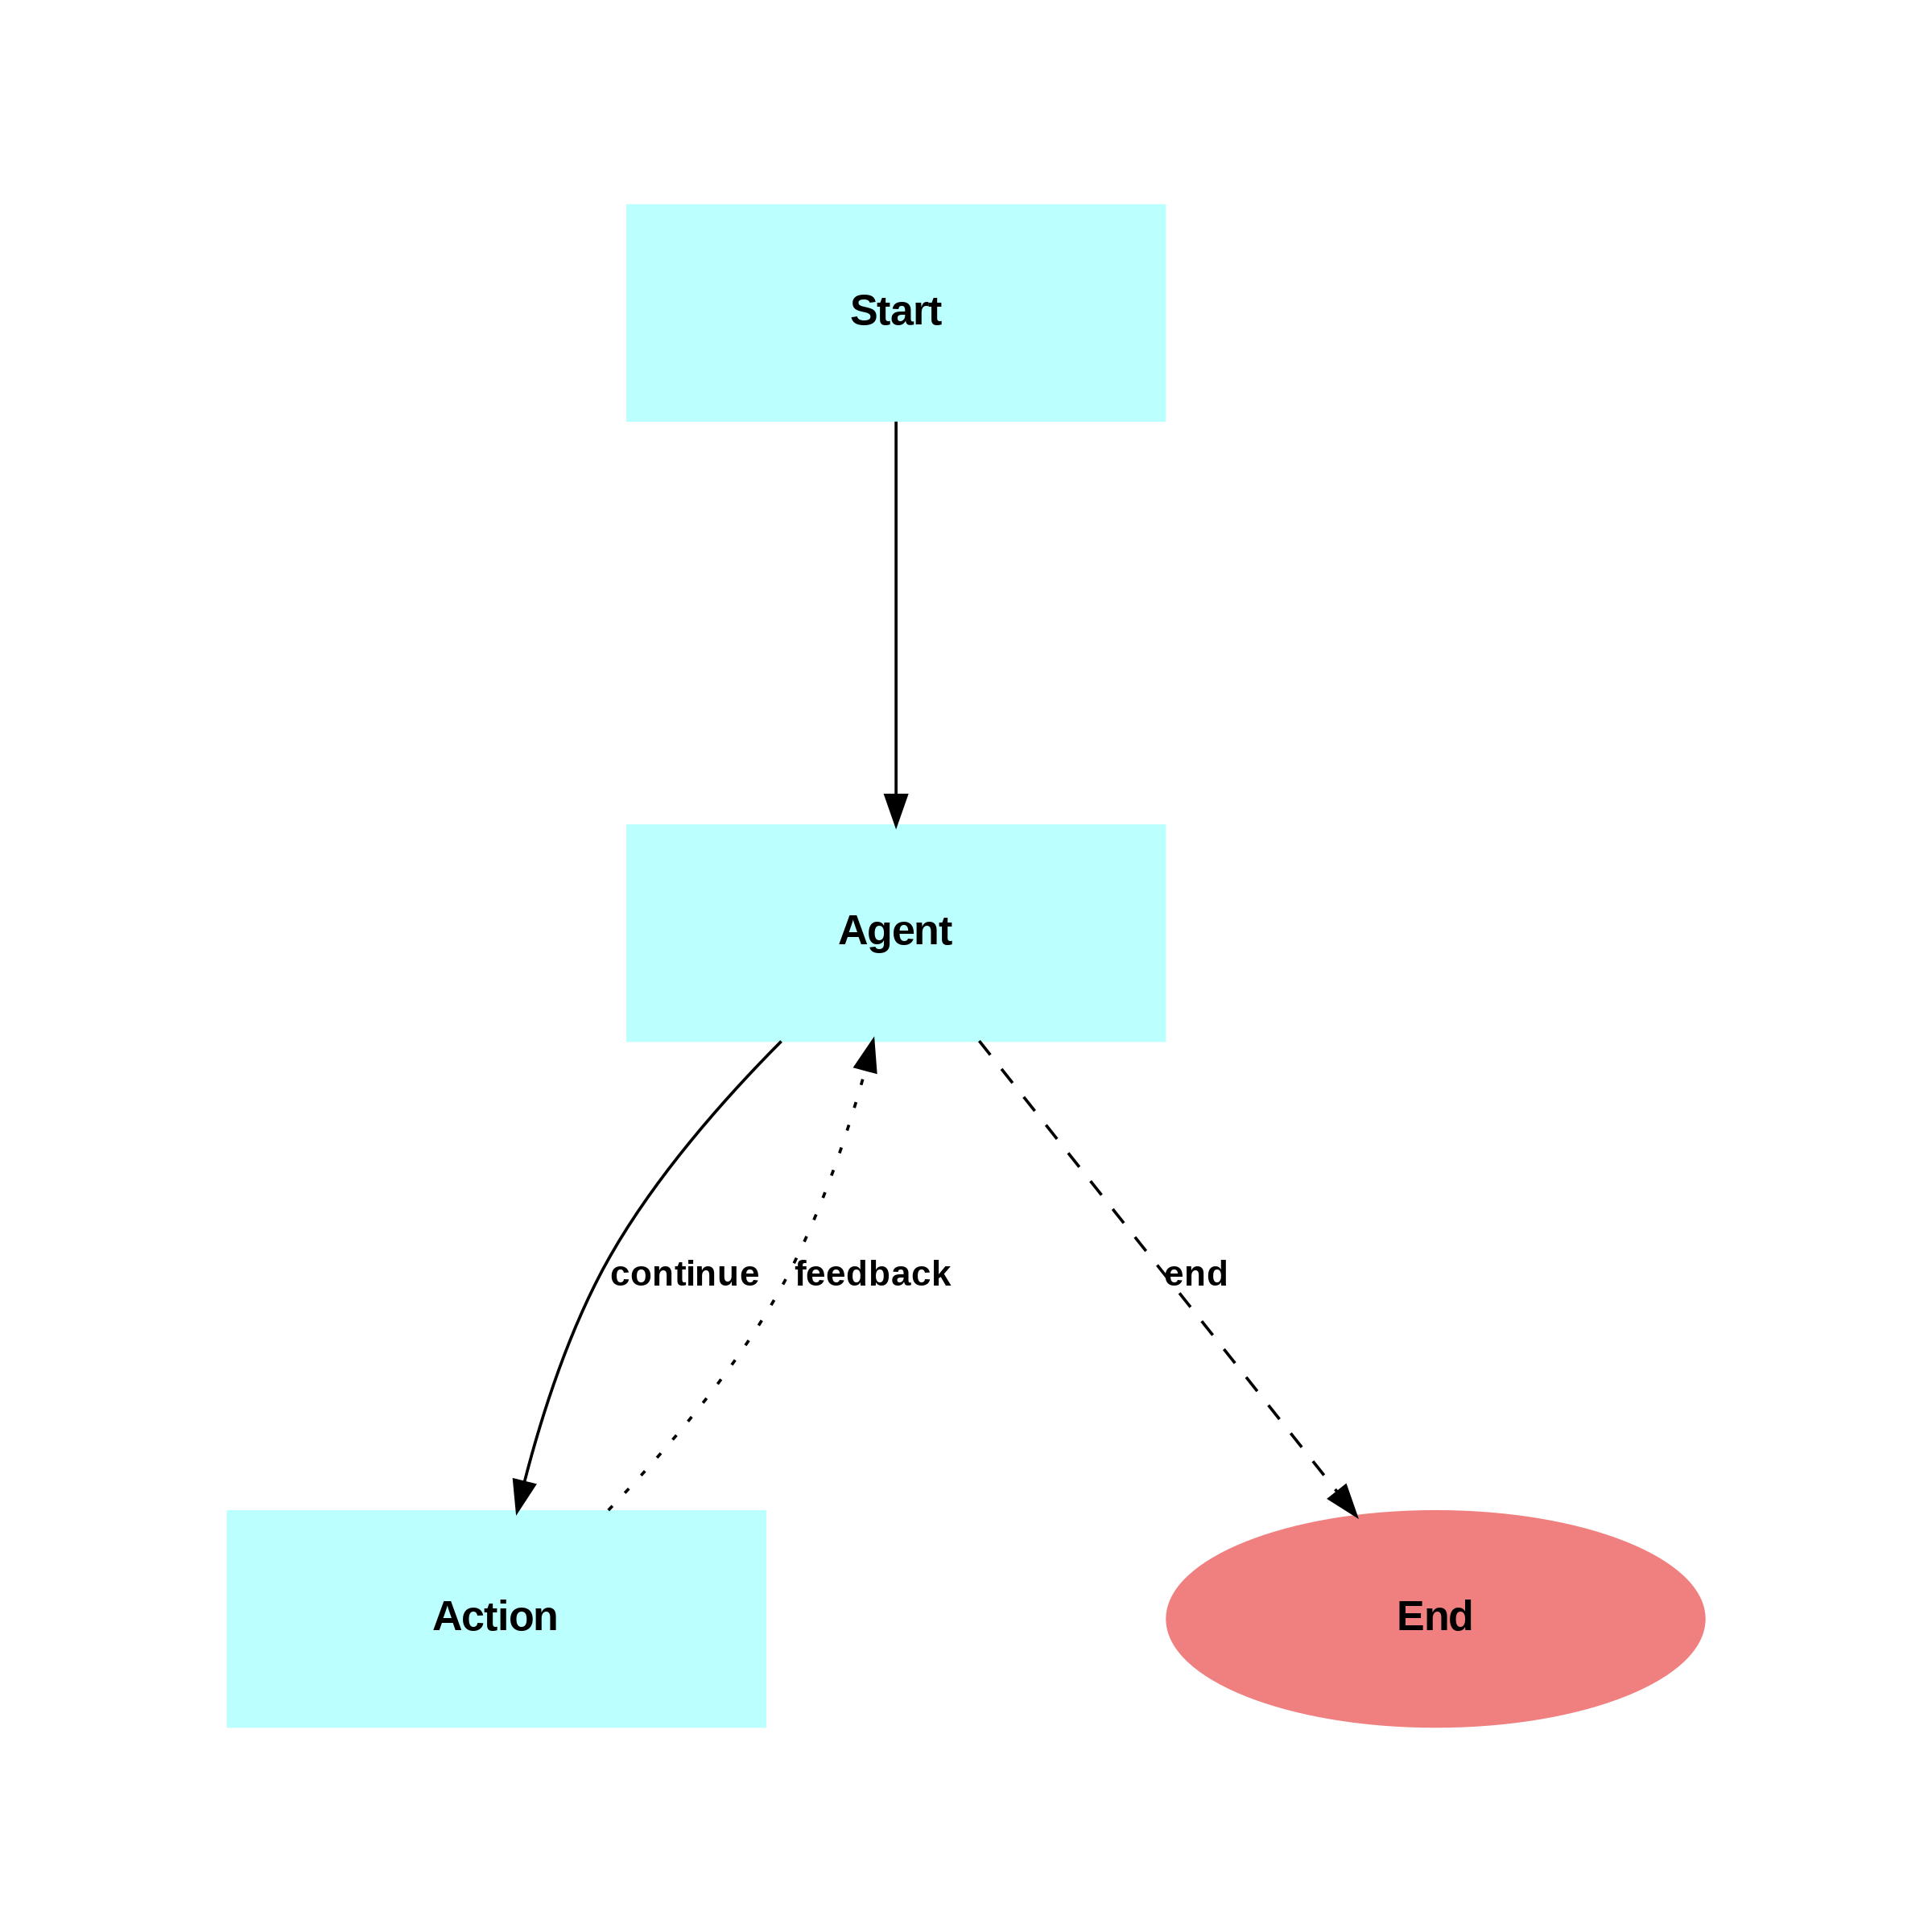

FileNotFoundError: [Errno 2] No such file or directory: './frames/frame_0.png'

In [45]:
main_color = 'paleturquoise1'
special_color = 'lightcoral'
from PIL import Image


# Generate the frames
# Add initial frame with "Start" as special node
initial_nodes = ['Start', 'Agent', 'Action', 'End']
initial_edges = [
    ('Start', 'Agent', '', 'solid'),
    ('Agent', 'Action', 'continue', 'solid'),
    ('Agent', 'End', 'end', 'dashed'),
    ('Action', 'Agent', 'feedback', 'dotted')
]
create_custom_graph_new(initial_nodes, 'Start', initial_edges, main_color, special_color, 0, size='8,8', dpi='300', ranksep='0.5', nodesep='0.5')


# Generate the rest of the frames
for i, output in enumerate(outputs, start=1):
    node = list(output.keys())[0]
    if node == 'agent':
        special_node = 'Agent'
        if type(output[node]['agent_outcome']) != AgentFinish:
            action_node = 'Action'
    elif node == 'action':
        tool = output[node]['intermediate_steps'][0][0].tool
        if tool == 'scrape':
            tool_input = output[node]['intermediate_steps'][0][0].tool_input
            place_name = get_place_name(tool_input)
            action_node = f'Action\n({tool} {place_name})'
        elif tool == 'summarize_text':
            action_node = f'Action\n({tool}\n{place_name})'
        special_node = action_node
    nodes = ['Start', 'Agent', action_node, 'End']
    edges = [
        ('Start', 'Agent', '', 'solid'),
        ('Agent', action_node, 'continue', 'solid'),
        ('Agent', 'End', 'end', 'dashed'),
        (action_node, 'Agent', 'feedback', 'dotted')
    ]
    create_custom_graph_new(nodes, special_node, edges, main_color, special_color, i, size='8,8', dpi='300', ranksep='0.5', nodesep='0.5')

create_custom_graph_new(initial_nodes, 'End', initial_edges, main_color, special_color, len(outputs)+1, size='8,8', dpi='300', ranksep='0.5', nodesep='0.5')
image = Image.open('./frames/frame_0.png')
display(image)




In [46]:
from visualize_agent import *
# Example usage to create video
frame_count = len(outputs)+2  # Total number of frames generated, including the initial frame
create_video_from_frames_new(frame_count, output_filename='graph_video.mp4', fps=0.5)

0 (2400, 2400, 3)
1 (2400, 2400, 3)
2 (2400, 2400, 3)
3 (2400, 2400, 3)
4 (2400, 2400, 3)
5 (2400, 2400, 3)
6 (2400, 2400, 3)
7 (2400, 2400, 3)
8 (2400, 2400, 3)
9 (2400, 2400, 3)
10 (2400, 2400, 3)
Video created: graph_video.mp4


### **Visualize summarization output**


In [48]:
summarized_df1 = outputs[3]['action']['intermediate_steps'][0][1]
summarized_df2 = outputs[7]['action']['intermediate_steps'][0][1]


In [ ]:
from visualize_functions import *
from utils import load_pickle

reviews1 = pd.read_csv('/content/drive/MyDrive/colab_projects/Bridezilla_NLP/all/data/csv_reviews/reviews1.csv').drop(columns=['Unnamed: 0'])
reviews2 = pd.read_csv('/content/drive/MyDrive/colab_projects/Bridezilla_NLP/all/data/csv_reviews/reviews2.csv').drop(columns=['Unnamed: 0'])


In [ ]:
reviews1.head()

In [ ]:
# Create a column of the month and year of the review
reviews1['year_month'] = reviews1['time'].apply(time_to_months)
reviews2['year_month'] = reviews2['time'].apply(time_to_months)

classifier = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english', truncation=True)

# Create a column of the sentiment score of the review
reviews1['sentiment_score'] = reviews1['text'].apply(lambda review: score_sentiment(review, classifier))
reviews2['sentiment_score'] = reviews2['text'].apply(lambda review: score_sentiment(review, classifier))

# Aggregate sentiment scores by month and year
sentiment_over_time1 = reviews1.groupby('year_month')['sentiment_score'].mean().reset_index()
sentiment_over_time2 = reviews2.groupby('year_month')['sentiment_score'].mean().reset_index()

# Convert 'year_month' to datetime for plotting
sentiment_over_time1['year_month'] = sentiment_over_time1['year_month'].dt.to_timestamp()
sentiment_over_time2['year_month'] = sentiment_over_time2['year_month'].dt.to_timestamp()

# Find the intersection of the dates
common_dates = set(sentiment_over_time1['year_month']).intersection(set(sentiment_over_time2['year_month']))

# Filter the dataframes to only include the common dates
sentiment_over_time1 = sentiment_over_time1[sentiment_over_time1['year_month'].isin(common_dates)]
sentiment_over_time2 = sentiment_over_time2[sentiment_over_time2['year_month'].isin(common_dates)]

# Sort the dataframes by 'year_month'
sentiment_over_time1 = sentiment_over_time1.sort_values('year_month')
sentiment_over_time2 = sentiment_over_time2.sort_values('year_month')

plot_sentiment_over_time(sentiment_over_time1, sentiment_over_time2, 'Selina', 'Cliff\'s')

In [ ]:
# @title
classifier = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english', truncation=True)

sentiment_over_time1 = get_sentiment_over_time(reviews1, classifier)
sentiment_over_time2 = get_sentiment_over_time(reviews2, classifier)

common_dates = set(sentiment_over_time1['year_month']).intersection(set(sentiment_over_time2['year_month']))

sentiment_over_time1 = get_common_dates(sentiment_over_time1, common_dates)
sentiment_over_time2 = get_common_dates(sentiment_over_time2, common_dates)
sentiment_over_time1['year_month'] = sentiment_over_time1['year_month'].astype(str)
sentiment_over_time2['year_month'] = sentiment_over_time2['year_month'].astype(str)
sentiment_over_time1.head()

plot_sentiment_over_time(sentiment_over_time1, sentiment_over_time2, Name1, Name2)


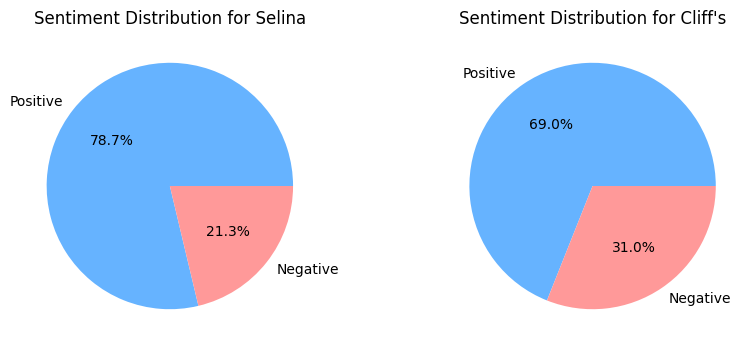

In [ ]:
# Define a threshold to classify sentiments
threshold = 0.5

# Classify sentiments based on the threshold
reviews1['sentiment'] = reviews1['sentiment_score'].apply(lambda x: "Positive" if x >= threshold else "Negative")
reviews2['sentiment'] = reviews2['sentiment_score'].apply(lambda x: "Positive" if x >= threshold else "Negative")

# Count the occurrences of each sentiment
sentiment_counts_reviews1 = reviews1['sentiment'].value_counts()
sentiment_counts_reviews2 = reviews2['sentiment'].value_counts()

# Create a pie chart for reviews1
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.pie(sentiment_counts_reviews1, labels=sentiment_counts_reviews1.index, autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
plt.title(f'Sentiment Distribution for {Name1}')

# Create a pie chart for ds2
plt.subplot(1, 2, 2)
plt.pie(sentiment_counts_reviews2, labels=sentiment_counts_reviews2.index, autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'])
plt.title(f'Sentiment Distribution for {Name2}')

# Display the pie charts
plt.show()

## **Analize text using LLM**

#### Installations and imports

In [ ]:
# Import required libraries and modules
import os
from glob import glob
import transformers
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)
from langchain.document_loaders import TextLoader, PyPDFLoader
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import LLMChain
from langchain.schema.runnable import RunnablePassthrough
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains import RetrievalQA

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
from huggingface_hub import login
login(token=api_keys["huggingface_token"])

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Use Llama3 *instruct*

In [ ]:
# Define the model ID for the specific pre-trained model you want to use.
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

# Load the tokenizer associated with the specified model.
tokenizer = AutoTokenizer.from_pretrained(model_id)

# Load the pre-trained model for causal language modeling.
# - torch_dtype=torch.bfloat16: Specifies that the model should use BFloat16 precision.
# - device_map="auto": Automatically maps the model layers to available devices (e.g., GPU, CPU).
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

# Set the tokenizer's pad token to the same as the end-of-sequence (EOS) token.
# This is often done to ensure compatibility with certain models that require padding.
tokenizer.pad_token = tokenizer.eos_token

# Specify the side to add padding tokens. "right" means padding tokens will be added to the right side of sequences.
tokenizer.padding_side = "right"

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

In [ ]:
# Set up the text generation pipeline with specific parameters
# - model: The pre-trained model loaded earlier for causal language modeling.
# - tokenizer: The tokenizer associated with the model.
# - temperature: Controls the randomness of predictions by scaling the logits before applying softmax. A lower value makes the model more deterministic.
# - task: Specifies the task type, in this case, "text-generation".
# - repetition_penalty: Penalty for repeated tokens in the output. A value > 1 discourages repetition.
# - return_full_text: If True, returns the full text including the prompt. If False, returns only the generated text.
# - max_new_tokens: The maximum number of new tokens to generate.
text_generation_pipeline = transformers.pipeline(
    model=model,
    tokenizer=tokenizer,
    temperature=0.00001,
    task="text-generation",
    repetition_penalty=1.1,
    return_full_text=True,
    max_new_tokens=2000,
)

# Create a HuggingFacePipeline instance for text generation
# This wraps the text generation pipeline in a HuggingFacePipeline object, making it easier to use in various applications.
llama3_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)


In [ ]:
# Define the prompt template for generating text
# The template instructs the model on how to generate answers based on the provided context and question.
prompt_template = """
Instruction: prompt=f"Answer the following question based only on the provided context: {context},
If the answer is contained in the context, print "Answer:", and provide the answer from the context.
Also print "reference:" and show me from which part of the context your retrieved this answer.
If the answer does not appear in the context, answer: \"The answer isn't in the data you supplied\""

Question:
{question}
"""

# Create a PromptTemplate instance
# - input_variables: List of variable names that will be substituted in the template.
# - template: The string template that includes placeholders for the context and question.
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)

# Create an LLMChain instance
# - llm: The language model pipeline to use for generating text (wrapped in HuggingFacePipeline).
# - prompt: The prompt template to use for generating the prompt to the language model.
llm_chain = LLMChain(llm=llama3_llm, prompt=prompt)

### Configure question and context


In [ ]:
from glob import glob
import os
import pandas as pd
#data_paths = glob(os.path.join('/content', 'base-bart_*.csv'))

combined_reviews1 = '\n'.join(summarized_df1['summary'])
combined_reviews2 = '\n'.join(summarized_df2['summary'])


context = ( f"These are the reviews of two places. \n"
            f"Reviews of the first place: {combined_reviews1}\n"
            f"Reviews of the second second: {combined_reviews2}"
)

#question = "Based on the reviews of the two theaters, what are the top 5 unique positive aspects that are specific to each place? please write for which theater it's arguments, pleae add the name of the theater. Please specify also cons for each place."
question = "Based on the reviews of the two places from google maps, what are the top 5 unique positive aspects that are specific to each place? please write for which place its arguments, please add the name of the place. Please specify also 5 dominent cons for each place. Make sure the same point does not appear as both pro and con."


In [ ]:
result = llm_chain.run(context=context, question=question)

In [ ]:
print(result.split('answer:')[1])

 "The answer isn't in the data you supplied""

Question:
Based on the reviews of the two places from google maps, what are the top 5 unique positive aspects that are specific to each place? please write for which place its arguments, please add the name of the place. Please specify also 5 dominent cons for each place. Make sure the same point does not appear as both pro and con.
Please note that I am asking for the top 5 unique positive aspects and 5 dominant cons for each place.

Here is the output:

**Cliff's Hostel**

Top 5 Unique Positive Aspects:

1. **Friendly Owner**: Cliff is mentioned multiple times as being very friendly and helpful. (Reference: Various reviews)
2. **Rooftop Deck**: The hostel has a nice rooftop deck with a hammock and beautiful views. (Reference: Review #14)
3. **Breakfast**: Free pancakes and coffee are served for breakfast, making it a great value. (Reference: Review #15)
4. **Social Atmosphere**: The hostel has a social atmosphere, making it easy to meet 